In [37]:
import numpy as np
import pandas as pd
import ast 
import matplotlib.pyplot as plt
import seaborn as sns
from src.util import utils
from src.util.utils import *

In [38]:
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
plt.rcParams["font.size"]  = 25
sns.set_style('darkgrid')

## Matching the users to their groups
We have the following structure for the groups:

| Group 1 | Group 2|
| :----: | :---:|
|Adaptive Feedback | No Adaptive Feedback| 

In [39]:
dframe = df.copy()
all_keystrokes = list(map(lambda _ : ast.literal_eval(_) , df['ks'].values))
sorted_users = sorted(set(df['user_id'].values))
indices_of_first_attempts_per_user = dframe.groupby('user_id').head(1).index

# Comparing different Keystroke Features

First what we want to do is count the number of insertions and deletions for each student. 

**We consider an insertion as being any character that was typed without being in  `KEYWORDS`. (whitespaces included)**

**We consider deletions as being any character being equal to 'Backspace' or 'Delete'.**

we will create a tuple for each student of the form ```(total insertions, total deletions)```.
We create the same thing for each set of keystrokes in the dataset but it will be useful for later.

Also, what we do for each user: map their typing to insertions and deletions as **0s for insertions, 1s for deletions** and try to see what different sequences of inserts/delete all users have.

In [40]:
ins_del_dict = {'insert': 0, 'delete': 1}
student_sequences = []
recipe_sequences = []

recipe_insertions_deletions = []
user_insertions_deletions = []
for user in sorted_users:
    indices_where_written = dframe[dframe['user_id'] == user].index
    insertions = 0
    deletions = 0
    student_sequence = []
    for index in indices_where_written:
        ks_set = all_keystrokes[index]
        recipe_sequence = []
        recipe_insertion = 0
        recipe_deletion = 0
        for entry in ks_set:
            char = entry['character']
            if char not in KEYWORDS:
                #+1 to account for the space
                insertions += 1 
                recipe_insertion += 1
                student_sequence.append(ins_del_dict['insert'])
                recipe_sequence.append(ins_del_dict['insert'])
            elif char == 'Backspace' or char == 'Delete':
                deletions += 1
                recipe_deletion += 1
                student_sequence.append(ins_del_dict['delete'])
                recipe_sequence.append(ins_del_dict['delete'])

        recipe_sequences.append(recipe_sequence)       
        recipe_insertions_deletions.append((recipe_insertion, recipe_deletion))
                        
    student_sequences.append(student_sequence)
    user_insertions_deletions.append((insertions, deletions))

Now for any user, we map their insertions and deletions to the % of each and have pandas plot the % at each revision step. 
We also have a function that plots the total number of insertions and deletions.

Revision steps occur at each set of keystrokes when the `user_id` is the same. However, it is important to note some revision steps are not a revision steps but rather the start of another recipe. This is clearly visible in the plots when the number of insertions at step n is much smaller than the number of insertions at step n+1

We created a plot that takes any user index and returns the amount of revision they had with the % of deletions and insertions at each step

Here are useful functions.


In [41]:
def collect_data_from_user(user_index, columns = ['insertions', 'deletions']):
    """
    Collects all the content a user writes on the plaform.

    Args:
        user_index (int): user index to collect data from

    Returns:
        pd.DataFrame: a sublist of tuples from the given users revisions
    """
    assert user_index >= 0 and user_index < len(sorted_users)
    return pd.DataFrame(utils.compute_user_range(user_index, len(sorted_users), recipe_insertions_deletions, indices_of_first_attempts_per_user), columns=columns)

def plot_percentages_for_user(user_index):
    """
    Plots the percentages of insertions and deletions at each revision step t
    A bit of hardcoded constants but the data won't change overnight so ...
    Args:
        user_index (int): index of user to plot
    """
    assert user_index >= 0 and user_index < len(sorted_users)
    user_range = utils.compute_user_range(user_index, num_users=len(sorted_users), recipe_insertions_deletions=recipe_insertions_deletions, indices_of_first_attempts_per_user=indices_of_first_attempts_per_user)
    percentage = []
    for i, (insert,deletes) in enumerate(user_range):
        s = insert + deletes
        percentage.append((round(insert/s*100, 2), round(deletes/s*100, 2)))
    dfr = pd.DataFrame(percentage, columns=['insertion %', 'deletion %'])
    dfr.plot(kind='bar', xlabel='revision step for user ' + str(user_index) + ' : ' + sorted_users[user_index], ylabel='percentage', figsize=(8,8))
    
def plot_stats_for_user(user_index):
    """
    Same idea as percentages but this method plots the absolute numbers 
    of insertions and deletions

    Args:
        user_index (int): index of user to plot
    """
    assert user_index >= 0 and user_index < len(sorted_users)
    dfr = pd.DataFrame(utils.compute_user_range(user_index, len(sorted_users), recipe_insertions_deletions, indices_of_first_attempts_per_user), columns=['insertions', 'deletions'])
    dfr.plot(kind='bar', xlabel='revision step for user ' + str(user_index) + ' : ' + sorted_users[user_index], figsize=(8,8))
    

## Plotting different sessions

Now we create a function that plots the number of insertions per user per session. For example, user 1 writes 3 recipes and has 9 writing sessions so we want to differentiate each session to see what happens each time he writes a recipe.

In [42]:
user_to_recipes = get_map_user_to_recipes()

loading GloVe model
model loaded


In [43]:
def plot_users_sessions(user_index):
    recipe_indices = user_to_recipes[user_index].copy()
    recipe_indices.append(utils.get_last_index_where_written(user_index))
    for i, index in enumerate(recipe_indices):
        if i + 1 < len(recipe_indices):
            revisions = recipe_insertions_deletions[index: recipe_indices[i+1]]
            dfr = pd.DataFrame(revisions, columns=['insertions', 'deletions'])
            dfr.plot(kind='bar', xlabel='writing session number ' + str(i+1) +' for user '+ str(user_index) + ' : ' + sorted_users[user_index], figsize=(5,3))


def get_data_per_session(user_index):
    revisions = []
    recipe_indices = user_to_recipes[user_index].copy()
    recipe_indices.append(utils.get_last_index_where_written(user_index))
    for i, index in enumerate(recipe_indices):
        if i + 1 < len(recipe_indices):
            rev = recipe_insertions_deletions[index: recipe_indices[i+1]]
            dfr = pd.DataFrame(rev, columns=['insertions', 'deletions'])
            revisions.append(dfr)
    return revisions

### Now we work on different groups

In [44]:
max_num_revisions_each_group = []

def data_computation_on_groups(nth_revision, users_in_groups):
    """
    Computes
    - average amount of revisions
    - std amount of revisions
    - average revision length
    - std revision length
    - genders


    Args:
        nth_revision (int): the nth revision we want to work on
        users_in_groups (list(list(int))): the users in the groups we want to work on

    Returns:
        what we said earlier
    """
    max_revs_per_group = []
    amount_revisions_mean = []
    amount_revisions_std = []
    avrg_num_edits = []
    std_num_edits = []
    genders = []
    
    for group in users_in_groups:
        data_for_group = []
        group_revisions = []
        genders_for_group = []
        for user in group:
            genders_for_group.append(matching_data['gender'].iloc[user])
            try:
                data_for_sessions = get_data_per_session(user)[nth_revision]
            except: continue
            data_for_sessions = data_for_sessions.values
            l = list(map(lambda _ : len(_) , data_for_sessions))
            data_for_group.append(len(l)-1)     
            revisions = list(map(lambda _ : _[0] + _[1], data_for_sessions))
            if len(revisions) > 1:
                with_revision = revisions[1:] 
                for elem in with_revision:
                    group_revisions.append(elem)
                    
        genders.append(genders_for_group)
        avrg_num_edits.append(np.mean(group_revisions))
        std_num_edits.append(np.std(group_revisions))
        amount_revisions_mean.append(np.mean(data_for_group))
        amount_revisions_std.append(np.std(data_for_group))
        max_revs_per_group.append(max(data_for_group))
    return max_revs_per_group, amount_revisions_mean, amount_revisions_std, avrg_num_edits, std_num_edits, genders

### This section focuses on timing -- we compute the time spent revising as well as the pause times in the data

In [45]:
def get_time_spent_for_user(user_index, recipe_num):
    recipe_indices = user_to_recipes[sorted_users[user_index]].copy()
    if user_index == len(sorted_users) - 1: last_index_where_written = len(dframe)
    else: last_index_where_written = indices_of_first_attempts_per_user[user_index + 1]
    recipe_indices.append(last_index_where_written)
    try:
        if utils.has_revision(user_index, recipe_num, function=get_data_per_session):
            #for the first_time var --- in the data, the event date corresponds to the time at which they submit - hence when they first submit
            # they will start revising
            first_time = df.iloc[recipe_indices[recipe_num]]['event_date']
            second_time = df.iloc[recipe_indices[recipe_num+1]-1]['event_date']
        else: return 0
    except: 
        return 0
    return utils.time_difference(first_time, second_time)

def get_average_time_spent_per_group(group_num, recipe_num):
    time_spent = []
    for user in INDICES[group_num - 1]:
        time = get_time_spent_for_user(user, recipe_num)
        time_spent.append(time)
    return round(np.mean(time_spent), 2) if time_spent else 0

def get_std_time_spent_per_group(group_num, recipe_num):
    time_spent = []
    for user in INDICES[group_num - 1]:
        time = get_time_spent_for_user(user, recipe_num)
        time_spent.append(time)
    return round(np.std(time_spent), 2)

def get_total_time_spent_for_user(user_index):
    indices_where_written = df[df['user_id'] == sorted_users[user_index]].index
    first_time = df.loc[indices_where_written[0], 'event_date']    
    last_time = df.loc[indices_where_written[-1], 'event_date']
    return utils.time_difference(first_time, last_time)

In [46]:
def get_user_pause_time(user_index, recipe_num):
    recipe_indices = user_to_recipes[sorted_users[user_index]].copy()
    if user_index == len(sorted_users) - 1: last_index_where_written = len(dframe)
    else: last_index_where_written = indices_of_first_attempts_per_user[user_index + 1]
    recipe_indices.append(last_index_where_written)
    #the range we take starts at the time the user starts revising for that recipe
    try:
        t1= df.iloc[recipe_indices[recipe_num]+1: recipe_indices[recipe_num+1]]
    except : 
        return []
    return t1['ks'].values

def get_average_pause_time(ks_set):
    times = []
    """
    extract the average pause time from a keystroke set for certain indices

    Args:
        ks_set (json): a set of keystroke logs from which we extract 
    """
    ks_set = ast.literal_eval(ks_set)
    for index, entry in enumerate(ks_set):
        if index == len(ks_set) - 1:
            second_time = 0
        else:
            times.append(utils.time_difference_from_timestamps(entry['time']/1000, ks_set[index+1]['time']/1000))
    return np.mean(times) if times else 0

def get_average_pause_time_for_group(group_num, recipe_num):
    pause_times = []
    for user in INDICES[group_num - 1]:
        arr = []
        user_ks = get_user_pause_time(user, recipe_num=recipe_num)
        for ks in user_ks:
            arr.append(get_average_pause_time(ks_set=ks))
        pause_times.append(np.mean(arr) if arr else 0)
    #filter for not none for users who havent revised their texts. Pause times contains none because we start collecting pause times from first time users revise.
    return float(pd.DataFrame(pause_times).dropna().mean())

def get_std_pause_time_for_group(group_num, recipe_num):
    pause_times = []
    for user in INDICES[group_num - 1]:
        arr = []
        user_ks = get_user_pause_time(user, recipe_num=recipe_num)
        for ks in user_ks:
            arr.append(get_average_pause_time(ks_set=ks))
        pause_times.append(np.std(arr))
    #filter for not none for users who havent revised their texts. Pause times contains none because we start collecting pause times from first time users revise.
    return float(pd.DataFrame(pause_times).dropna().std())


#### Computing p-values for different feature variables

In [47]:
from scipy.stats import ttest_ind
def get_p_value_number_revisions(recipe_num):
    """
    Computes the p-value for the amount of revisions between groups
    """
    group1_amount_revs = []
    group2_amount_revs = []
    for user in INDICES[0]:
        data = get_data_per_session(user)[recipe_num]    
        group1_amount_revs.append(len(data)-1)
    for user in INDICES[1]:
        #one user in G2 did not write a third recipe...
        try:
            data = get_data_per_session(user)[recipe_num]
        except:
            continue
        group2_amount_revs.append(len(data)-1)

    return ttest_ind(group1_amount_revs, group2_amount_revs)[1]

In [48]:
def get_p_value_number_of_edits(recipe_num):
    """
    Computes the p-value for the number of revisions between groups

    we sum the total number of edits for 1 recipe for 1 user
    for example, for recipe 1, say a user has 5 revisions and then 8 other revisions 
    then we sum 5+8 = 13 total revisions for recipe 1
    """
    group1_number_revs = []
    group2_number_revs = []
    for user in INDICES[0]:
        if utils.has_revision(user, recipe_num=recipe_num, function=get_data_per_session):
            data = get_data_per_session(user)[recipe_num][1:]
            revisions = []
            for revision_session in data.values:
                revisions.append(revision_session[0] + revision_session[1])
            group1_number_revs.append(np.sum(revisions))

    for user in INDICES[1]:
        if utils.has_revision(user, recipe_num=recipe_num, function=get_data_per_session):
            try:
               data = get_data_per_session(user)[recipe_num][1:]
            except:
                continue
            revisions = []
            for revision_session in data.values:
                revisions.append(revision_session[0] + revision_session[1])
            group2_number_revs.append(np.sum(revisions))
    return ttest_ind(group1_number_revs, group2_number_revs)[1]

In [49]:
def get_p_value_time_spent(recipe_num):
    time_spent_group1 = []
    for user in INDICES[0]:
        time = get_time_spent_for_user(user, recipe_num)
        time_spent_group1.append(time)

    time_spent_group2 = []
    for user in INDICES[1]:
        time = get_time_spent_for_user(user, recipe_num)
        time_spent_group2.append(time)
    return ttest_ind(time_spent_group1, time_spent_group2)[1]    

In [50]:
import math
def get_p_value_pause_times(recipe_num):
    pause_time_group1 = []
    for user in INDICES[0]:
        arr = []
        user_ks = get_user_pause_time(user, recipe_num=recipe_num)
        for ks in user_ks: 
            arr.append(get_average_pause_time(ks_set=ks))
        if arr is not []:
            pause_time_group1.append(np.mean(arr) if arr else 0)


    pause_time_group2 = []
    for user in INDICES[1]:
        arr = []
        user_ks = get_user_pause_time(user, recipe_num=recipe_num)
        for ks in user_ks:
            arr.append(get_average_pause_time(ks_set=ks))
        if arr is not []:
            pause_time_group2.append(np.mean(arr) if arr else 0)
    
    pause_time_group1 = list(filter(lambda _ : not math.isnan(_), pause_time_group1))
    pause_time_group2 = list(filter(lambda _ : not math.isnan(_), pause_time_group2))
    return ttest_ind(pause_time_group1, pause_time_group2)[1]

In [51]:
try:
    p_values = []
    for recipes in range(3):
        p_values.append([get_p_value_number_revisions(recipes), get_p_value_number_of_edits(recipes), get_p_value_time_spent(recipes), get_p_value_pause_times(recipes)])
except:
    print("Error in p-value computation")
p_values = pd.DataFrame(p_values, columns=['p-value number of revisions', 'p-value number of edits', 'p-value time spent', 'p-value pause times'], index=['recipe1', 'recipe2', 'recipe3']).T
p_values.head()

,recipe1,recipe2,recipe3
p-value number of revisions,0.007169,0.033255,0.106786
p-value number of edits,0.234979,0.257971,0.455419
p-value time spent,0.693730,0.114382,0.905527
p-value pause times,0.339587,0.089960,0.859404


### Bubble plots & other plots

In [52]:
def compute_text_for_bubble_plots(group_num, recipe_num):
    max_revisions, means, stds, avrg_num_edits, std_num_edits ,_ = data_computation_on_groups(recipe_num, INDICES)
    return """
    Group {group}
    
    Maximum number of revisions: {max}
    {mean}
    {stds}
    {revision_edits_mean}
    {revisgit ion_edits_std}
    {average_time_spent}
    {std_time_spent}
    {average_pause_time}
    {std_pause_time}
    """.format(group='With Adaptive Feedback' if group_num == 1 else 'Without Adaptive Feedback',
    max=max_revisions[group_num-1], 
    mean=r'$\mu_{revisions}=%.3f$' % (means[group_num-1]), 
    stds=r'$\sigma_{revisions}=%.3f$' % (stds[group_num-1]),
    revision_edits_mean=r'$\mu_{revision lengths}=%.3f$' % (avrg_num_edits[group_num-1]),
    revision_edits_std=r'$\sigma_{revision lengths}=%.3f$' % (std_num_edits[group_num-1]),
    average_time_spent=r'$\mu_{time spent revising}=%.3f$' % (get_average_time_spent_per_group(group_num=group_num, recipe_num=recipe_num)),
    std_time_spent=r'$\sigma_{time spent revising}=%.3f$' % (get_std_time_spent_per_group(group_num=group_num, recipe_num=recipe_num)),
    average_pause_time='$\mu_{pause time} = %.3f$' % (get_average_pause_time_for_group(group_num=group_num, recipe_num=recipe_num)),
    std_pause_time=r'$\sigma_{pause time}=%.3f$' % (get_std_pause_time_for_group(group_num=group_num, recipe_num=recipe_num))
    )


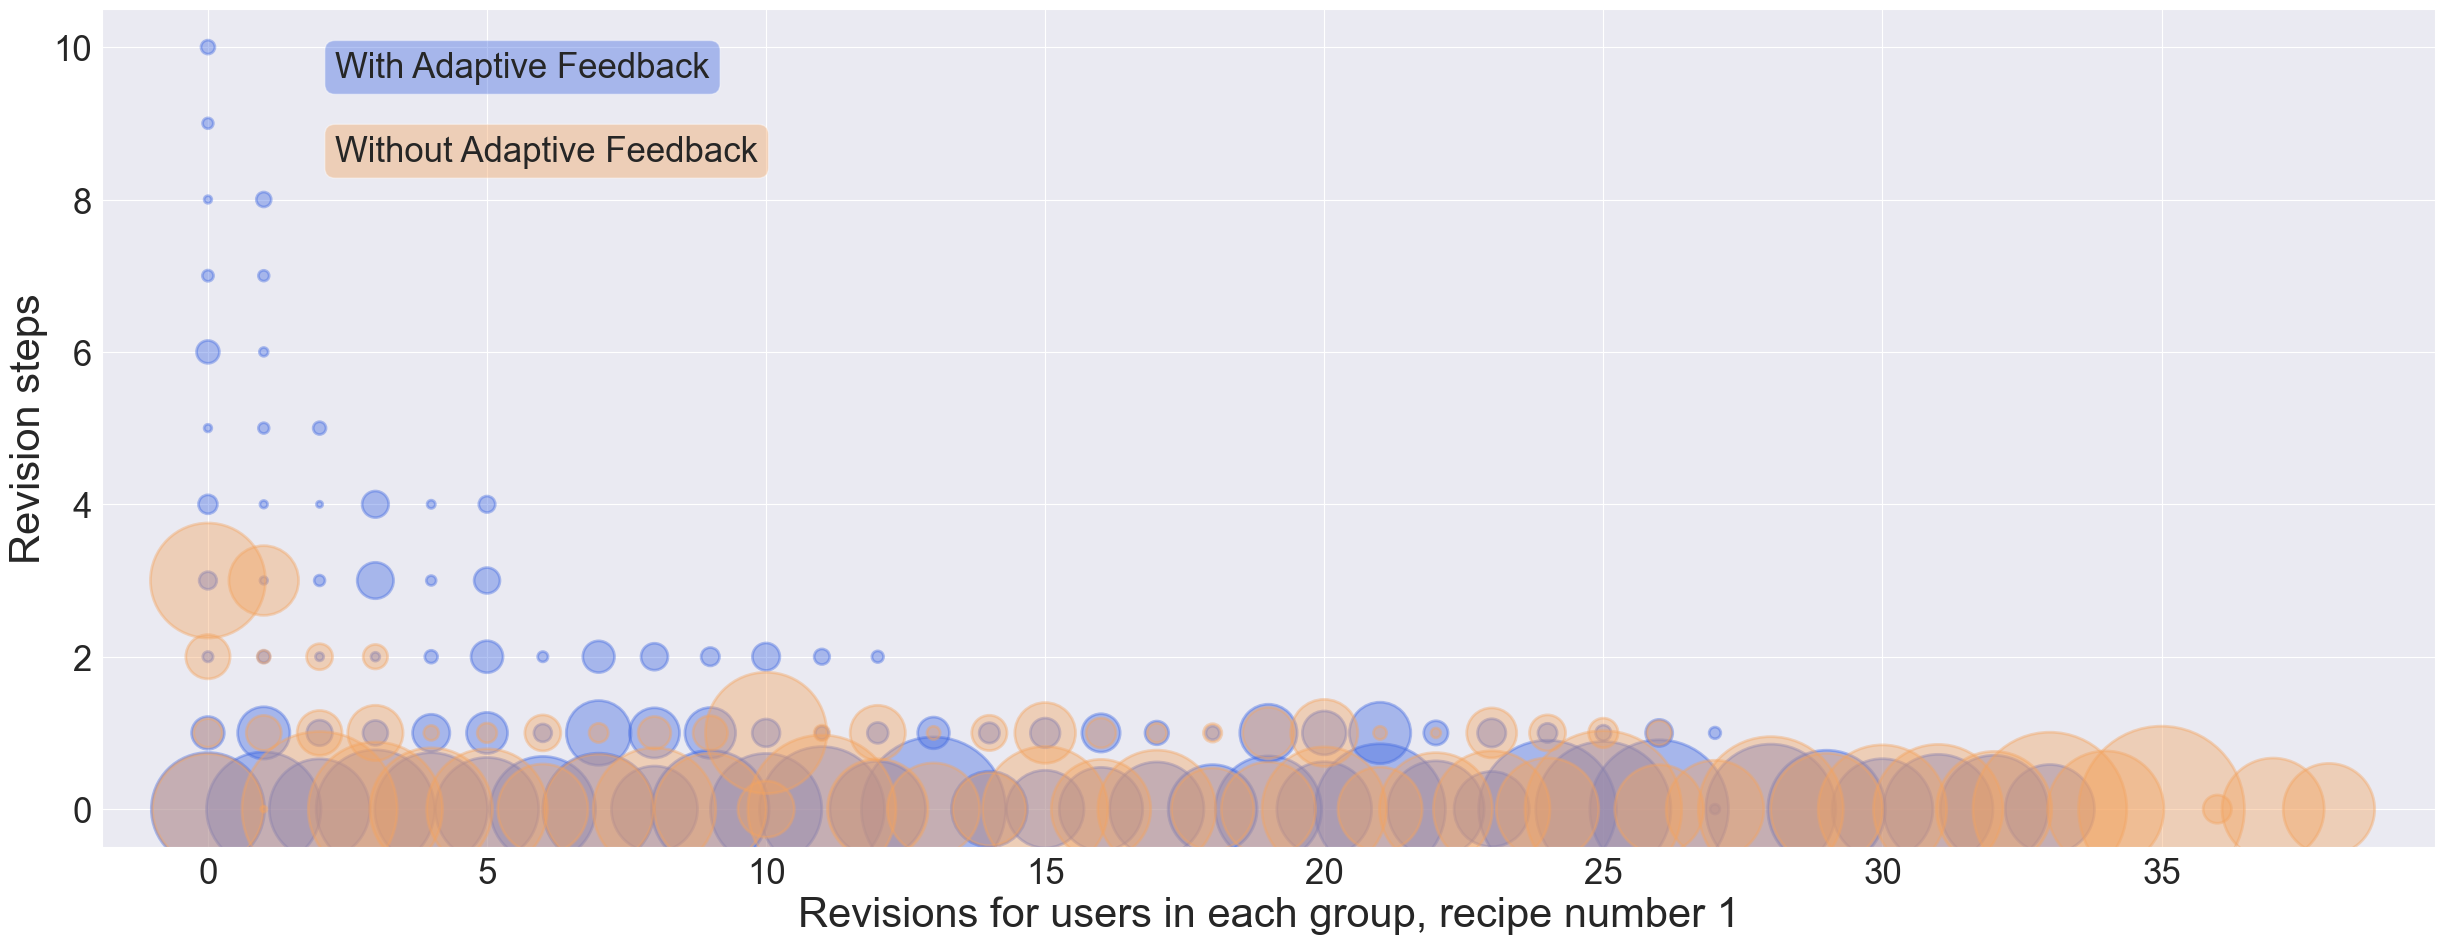

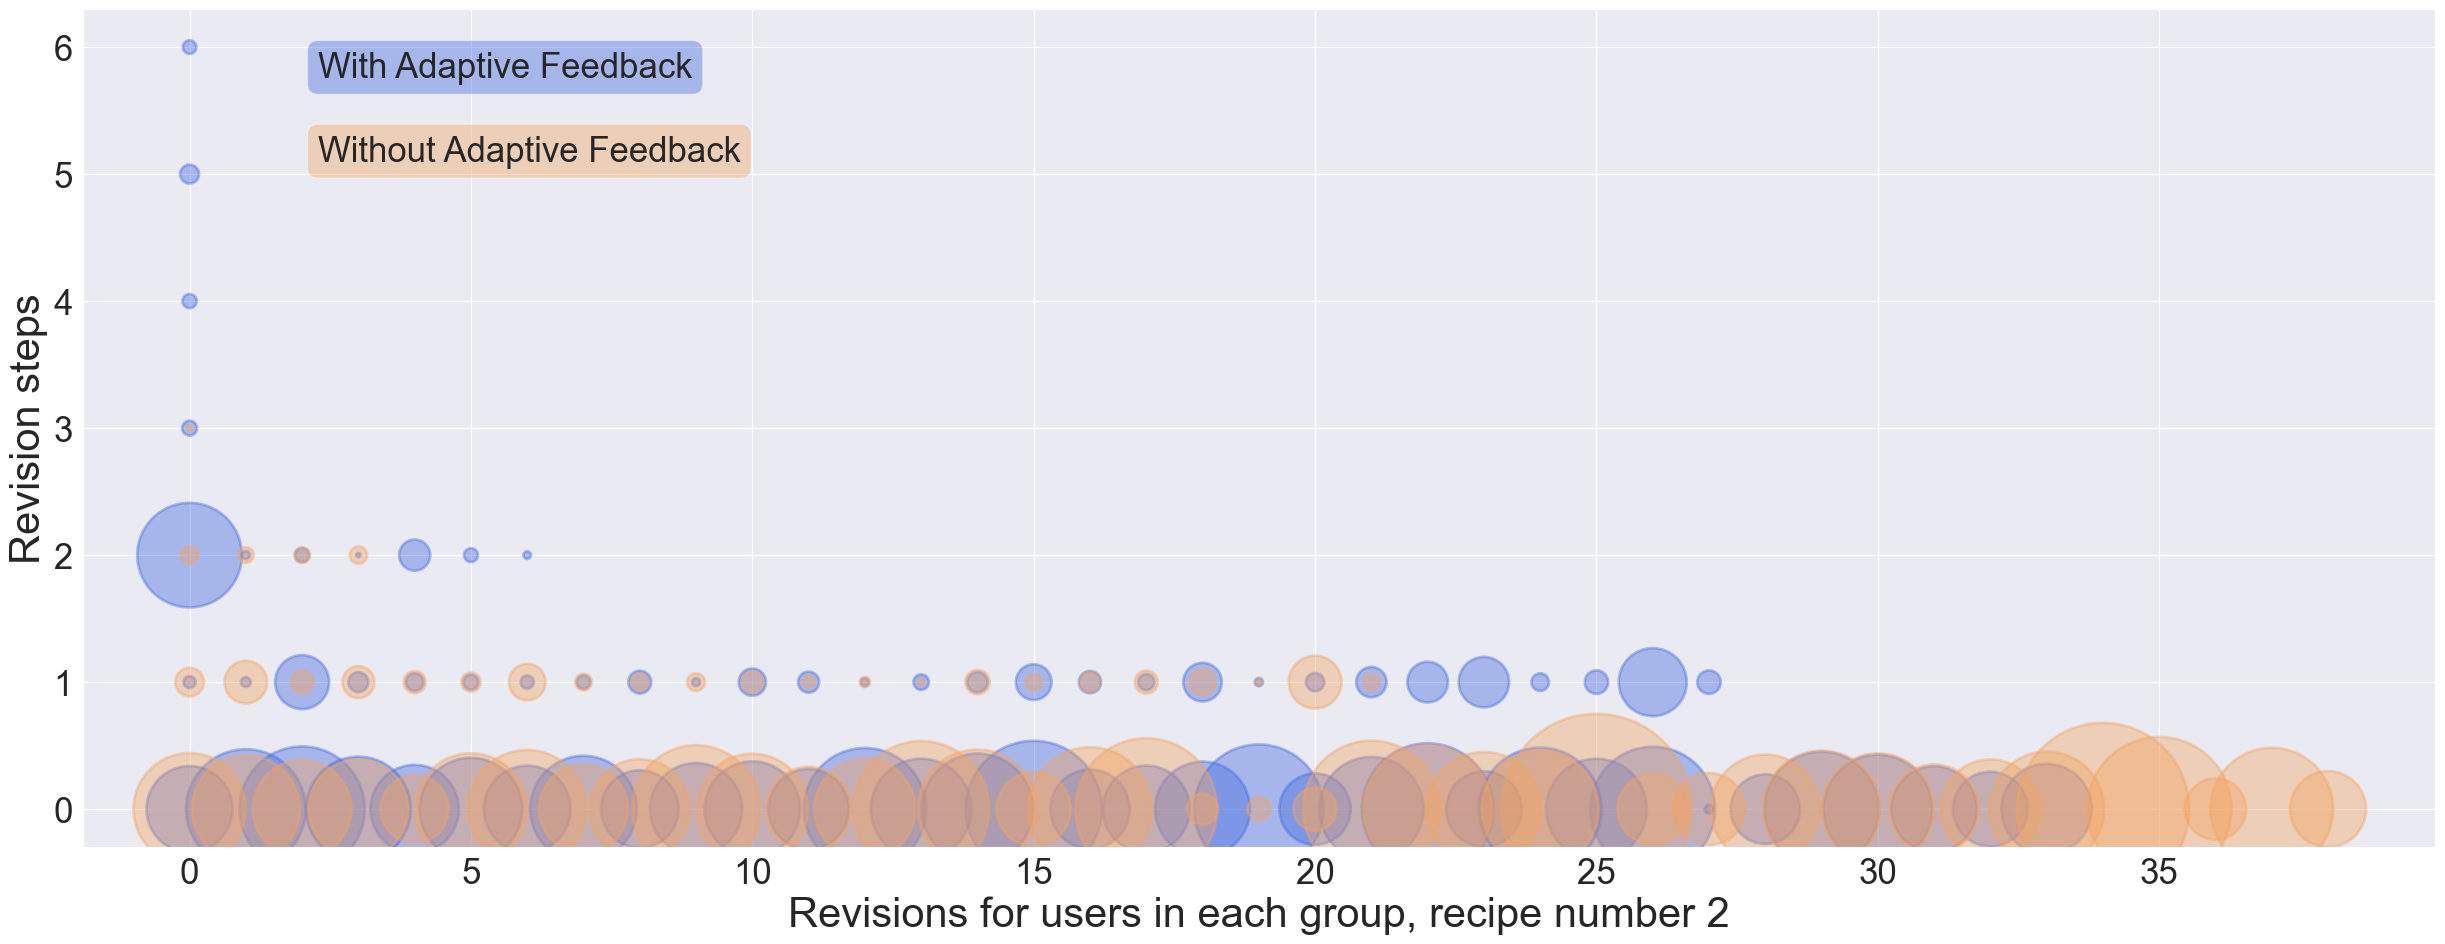

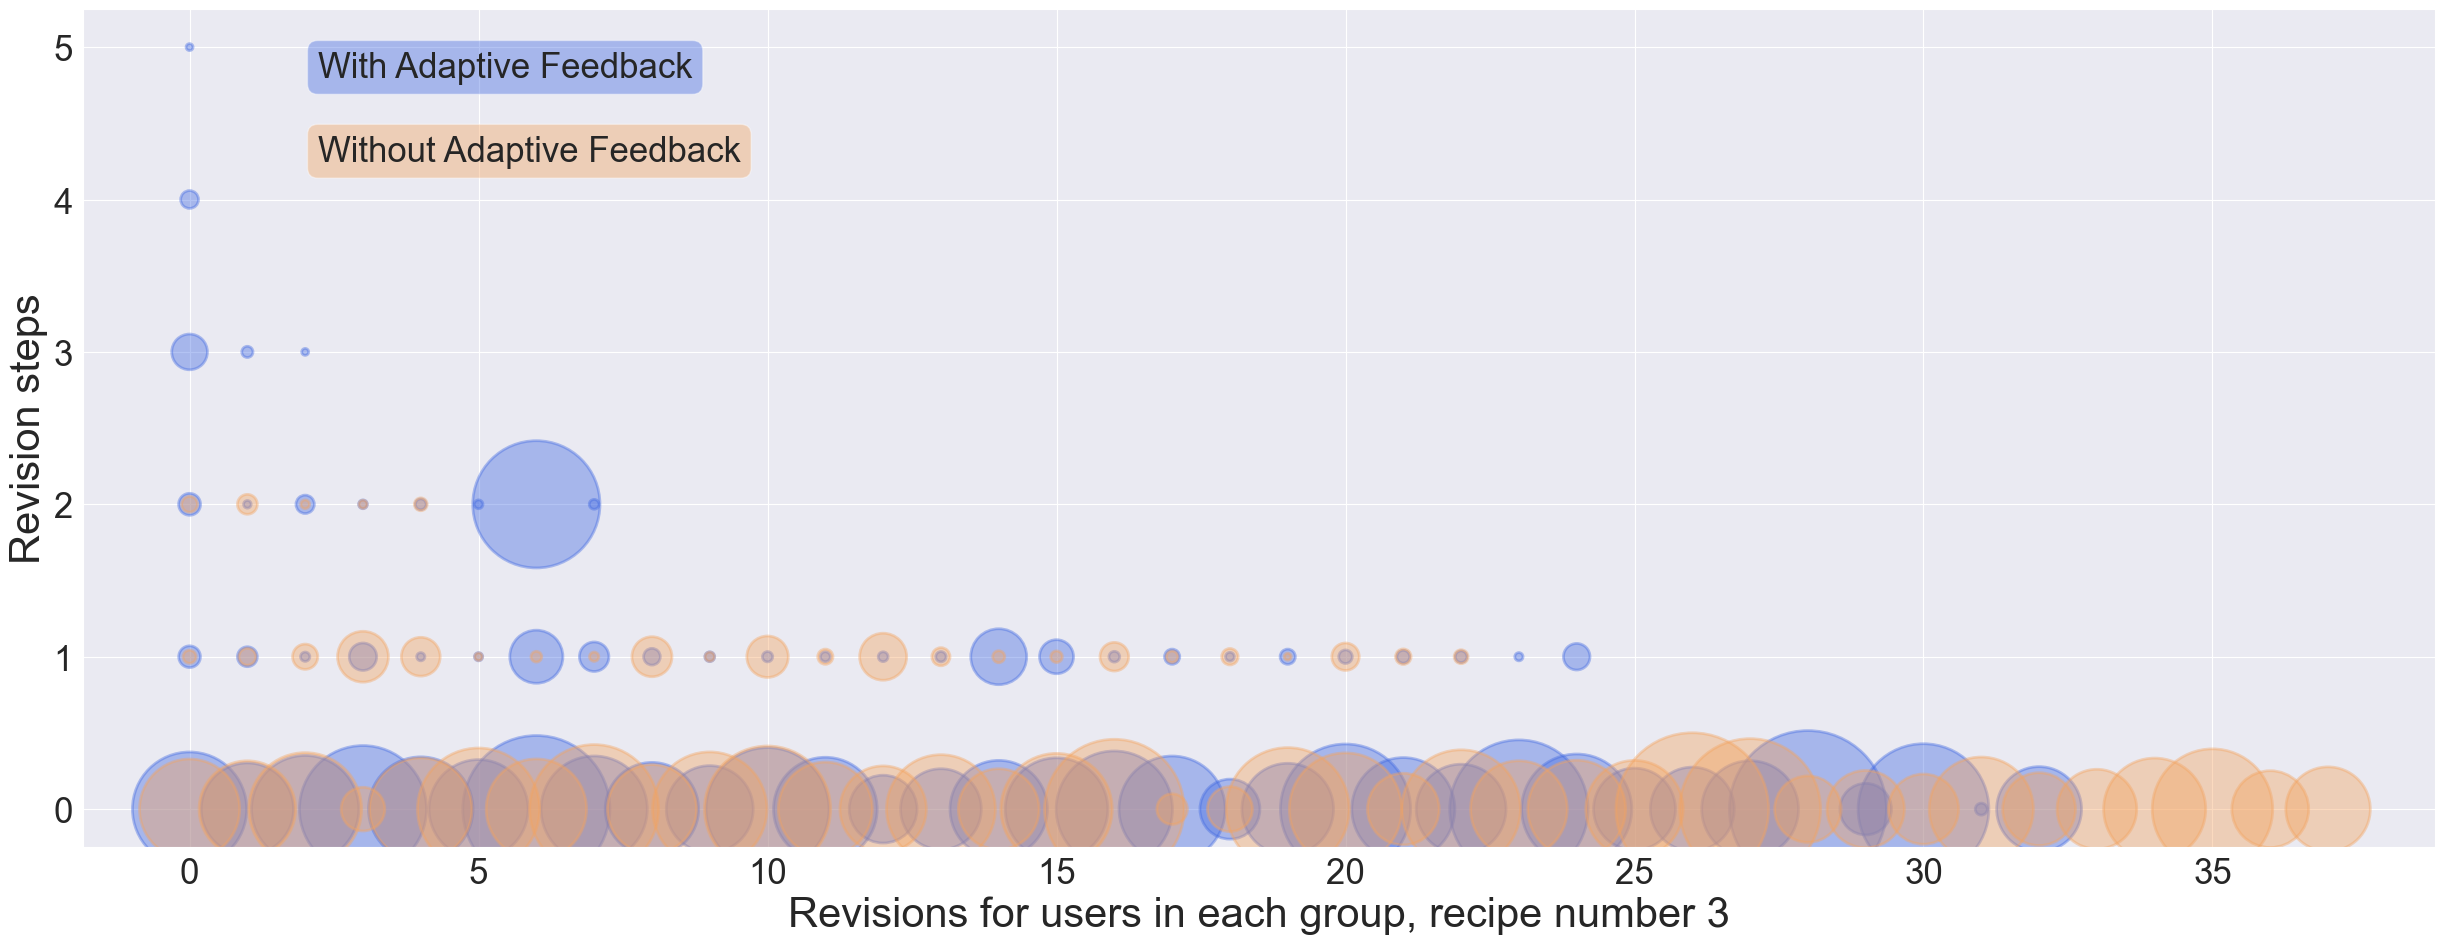

In [53]:
def bubble_plot(recipe_num, show_data=False, vertical=False): 
    if vertical:
        fig, ax = plt.subplots(figsize=(10,25), sharex=True, sharey=True)
    else :
        fig, ax = plt.subplots(figsize=(25,10), sharex=True, sharey=True)
    group_characteristics = ["With Adaptive Feedback", "Without Adaptive Feedback"]
    for group in [1,2]:
        data = []
        for i, _ in enumerate(sorted_users):
            if i in INDICES[group-1]:
                try: 
                    dfr = get_data_per_session(i)[recipe_num]
                    dfr.reset_index(inplace=True)
                    data.append(dfr)
                except: 
                        data.append(pd.DataFrame())

        data = (sorted(data, key = lambda dfr: len(dfr), reverse=True))
        list_of_df = [df for df in data]
        dframes = pd.concat(list_of_df)

        y = [[i]*len(list_of_df[i]) for i in range(len(list_of_df))]
        x = [np.arange(len(y_i)) for y_i in y ]
        x = [index for sub in x for index in sub]
        y = [i for sub in y for i in sub]

        ins = (dframes['insertions'].values)
        delete = (dframes['deletions'].values)
        revisions = ((ins + delete)*5).tolist()

        if not vertical:
            ax.scatter(x=y, y=x, s=revisions, alpha=0.4, linewidths=2, label=group_characteristics[group-1], c='royalblue' if group == 1 else 'sandybrown')
            plt.xlabel(xlabel='Revisions for users in each group, recipe number {num}'.format(num=recipe_num+1), fontsize=30)
            plt.ylabel(ylabel='Revision steps', fontsize=30)
        else : 
            ax.scatter(x=x, y=y, s=revisions, alpha=0.4, linewidths=2, label=group_characteristics[group-1], c='royalblue' if group == 1 else 'sandybrown')
            plt.xlabel(xlabel='Revision steps', fontsize=30)
            plt.ylabel(ylabel='Revisions for users in each group, recipe number {num}'.format(num=recipe_num+1), fontsize=30)
        # place a text box  in upper left in axes coords
        if show_data:
            text = compute_text_for_bubble_plots(group_num=group, recipe_num=recipe_num)
            props = dict(boxstyle='round', facecolor='w', alpha=0.8)
            ax.text(0.6 if group==1 else 0.8, 0.95, text, transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props)

        new_props = dict(boxstyle='round', facecolor='royalblue' if group == 1 else 'sandybrown', alpha=0.4)
        ax.text(0.1, 0.95 if group == 1 else 0.85, group_characteristics[group-1], transform=ax.transAxes, fontsize=25,
            verticalalignment='top', bbox=new_props)

    fig.tight_layout()
    plt.savefig('results/bubble plots/recipe {num}.png'.format(num=recipe_num+1))

bubble_plot(recipe_num=0, show_data=False, vertical=False)
bubble_plot(recipe_num=1, show_data=False, vertical=False)
bubble_plot(recipe_num=2, show_data=False, vertical=False)

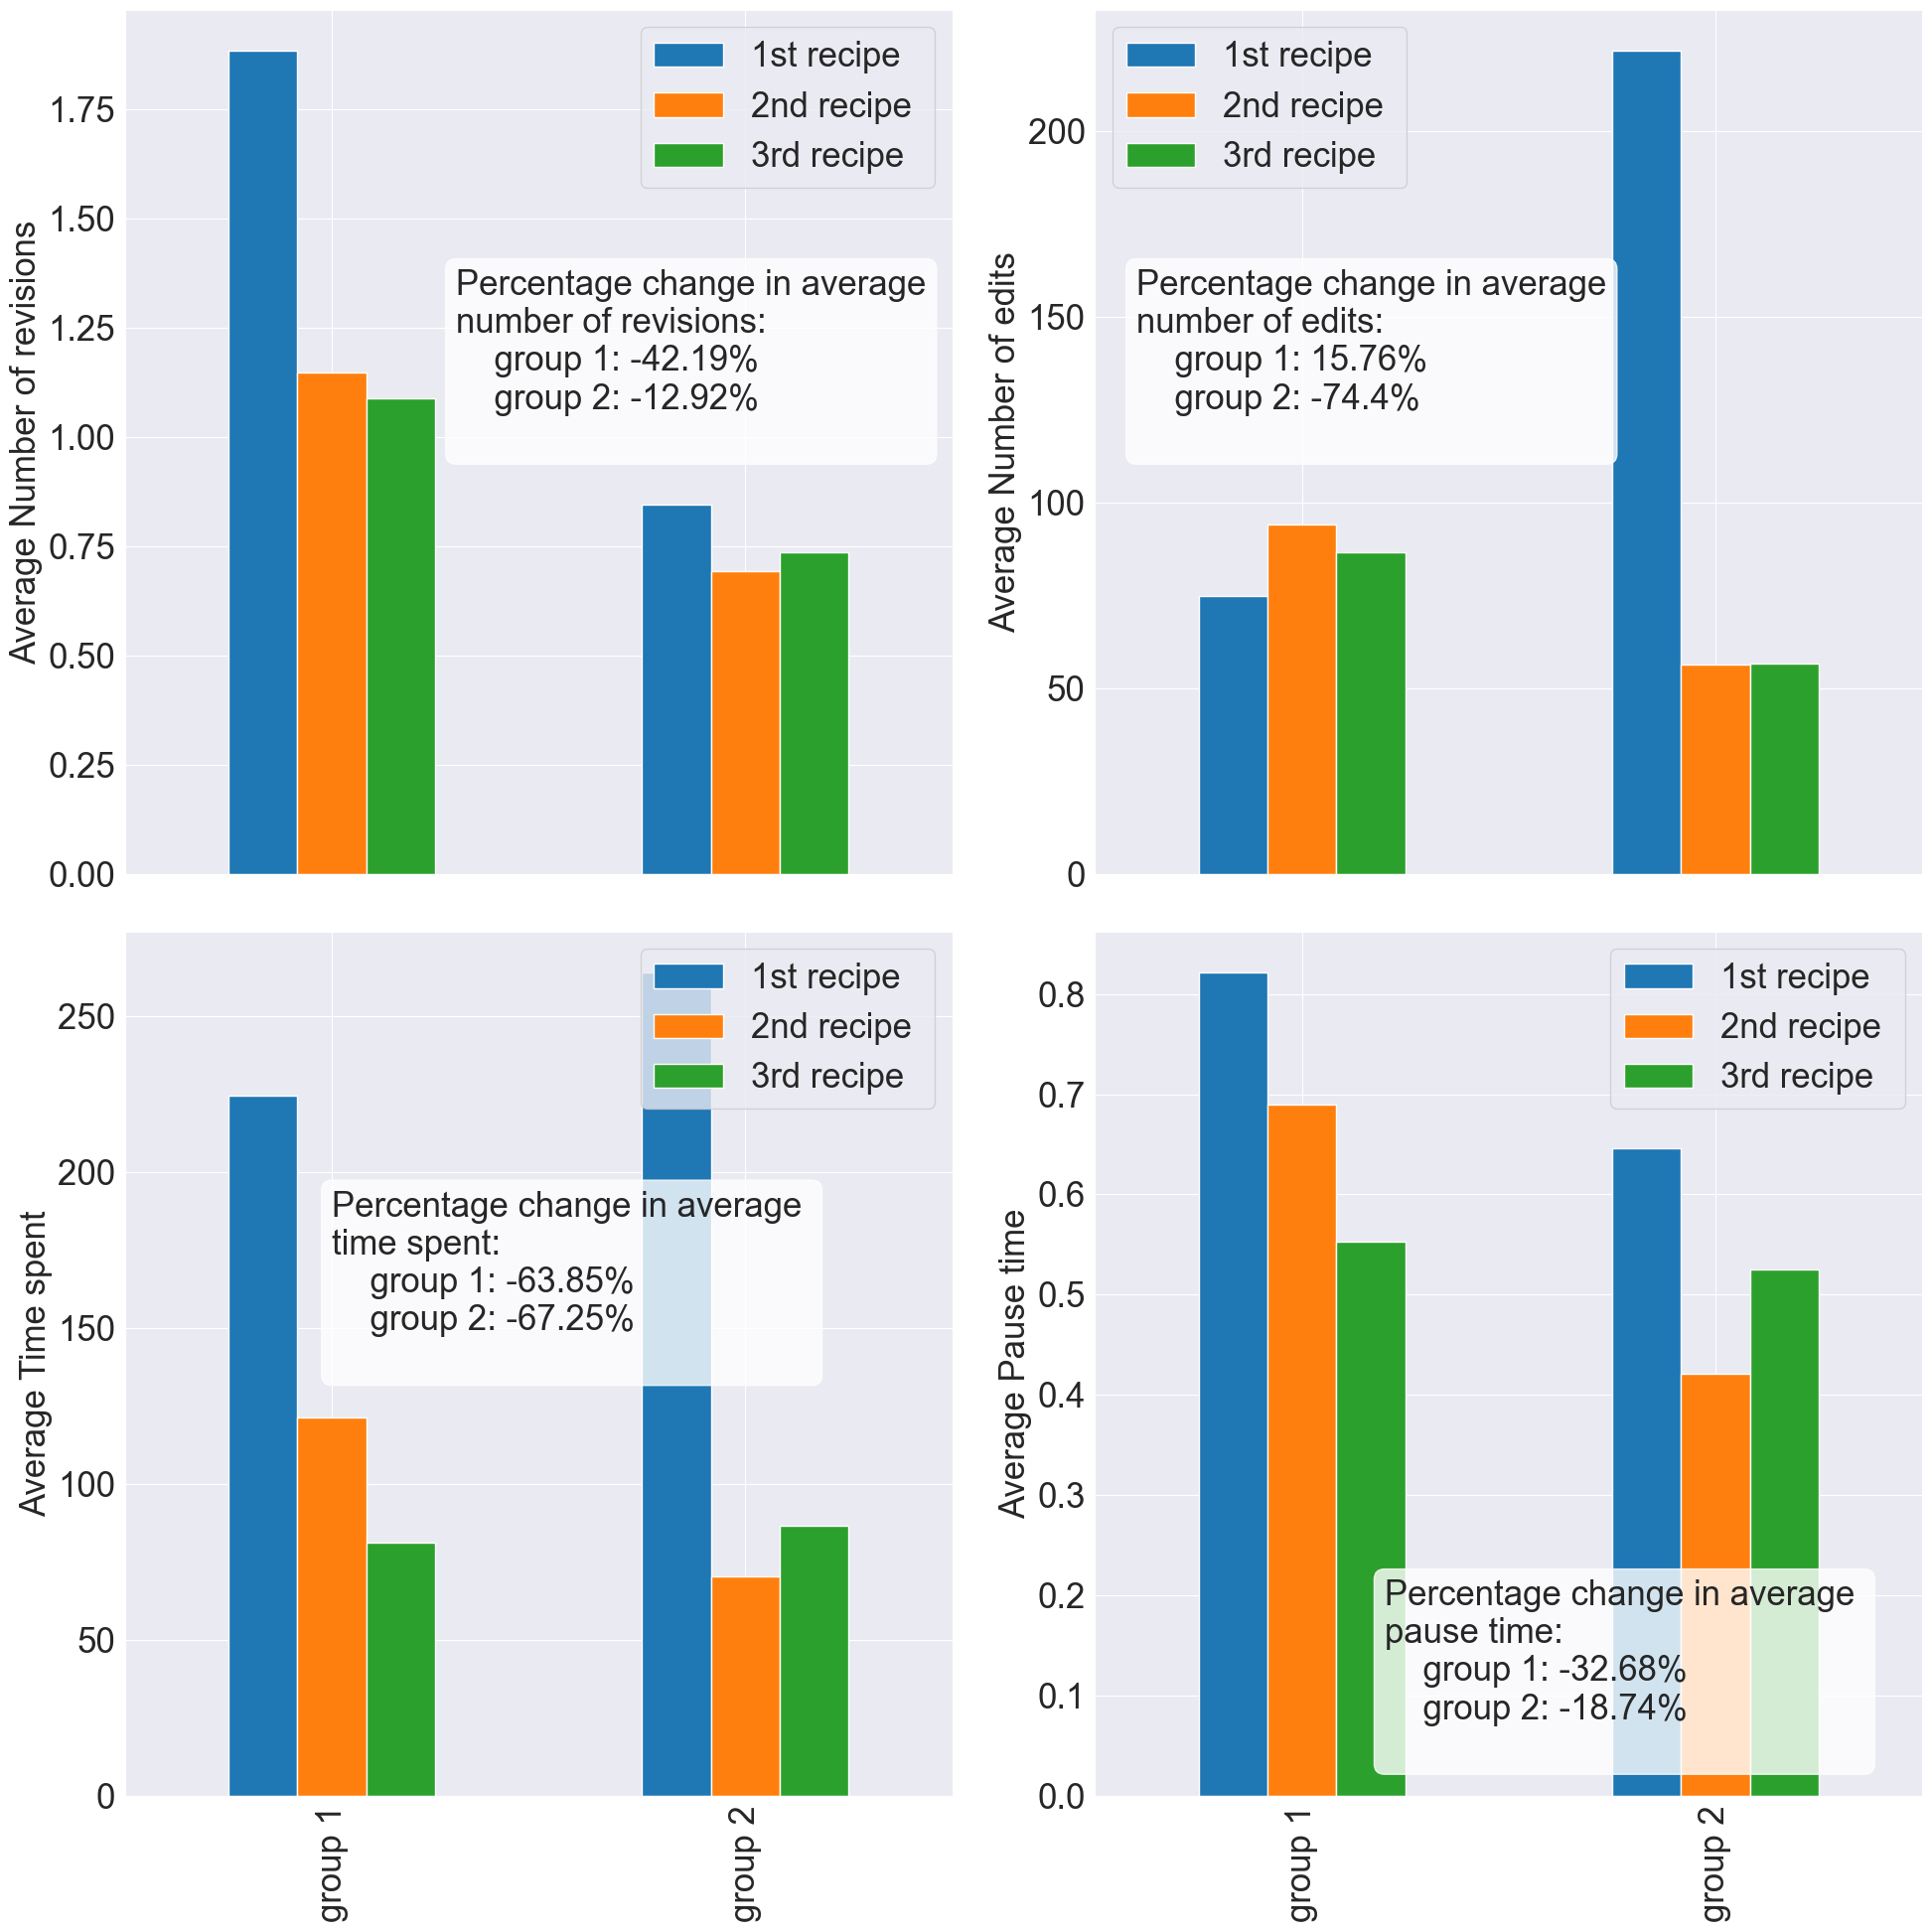

In [54]:
_, means_1, _, avr_rev_lengths_1, _, _ = data_computation_on_groups(0, INDICES)
_, means_2, _, avr_rev_lengths_2 ,_ , _ = data_computation_on_groups(1, INDICES)
_, means_3 , _, avr_rev_lengths_3, _ , _ = data_computation_on_groups(2, INDICES)
time_spent = []
pause_times = []
for group_num in [1,2]:
        time, pause_time = [], []
        for recipe_num in range(0,3):
                time.append(get_average_time_spent_per_group(group_num=group_num, recipe_num=recipe_num))
                pause_time.append(get_average_pause_time_for_group(group_num=group_num, recipe_num=recipe_num))
        time_spent.append(tuple(time))
        pause_times.append(tuple(pause_time))

means = pd.DataFrame((zip(means_1, means_2, means_3)), columns=['1st recipe', '2nd recipe ', '3rd recipe'], index=['group 1', 'group 2'])
avr_rev_lengths = pd.DataFrame((zip(avr_rev_lengths_1, avr_rev_lengths_2, avr_rev_lengths_3)), columns=['1st recipe', '2nd recipe ', '3rd recipe'], index=['group 1', 'group 2'])
time_spent = pd.DataFrame(time_spent, columns=['1st recipe', '2nd recipe ', '3rd recipe'], index=['group 1', 'group 2'])
pause_times = pd.DataFrame(pause_times, columns=['1st recipe', '2nd recipe ', '3rd recipe'], index=['group 1', 'group 2'])

fig, ax = plt.subplots(2, 2, sharex=True)

figsize = (20,20)

ax[0][0].set_ylabel('Average Number of revisions', fontsize=25)
ax[0][1].set_ylabel('Average Number of edits', fontsize=25)
ax[1][0].set_ylabel('Average Time spent', fontsize=25)
ax[1][1].set_ylabel('Average Pause time', fontsize=25)
means.plot(kind='bar', figsize=figsize, ax=ax[0][0])
avr_rev_lengths.plot(kind='bar', figsize=figsize, ax=ax[0][1])
time_spent.plot(kind='bar', figsize=figsize, ax=ax[1][0])
pause_times.plot(kind='bar', figsize=figsize, ax=ax[1][1])
fig.tight_layout()

props = dict(boxstyle='round', facecolor='w', alpha=0.8)
ax[0][0].text(0.4, 0.7, utils.compute_text('average\nnumber of revisions:', means), transform=ax[0][0].transAxes, fontsize=25,
        verticalalignment='top', bbox=props)
ax[0][1].text(0.05, 0.7, utils.compute_text('average\nnumber of edits:', avr_rev_lengths), transform=ax[0][1].transAxes, fontsize=25,
        verticalalignment='top', bbox=props)
ax[1][0].text(0.25, 0.7, utils.compute_text('average \ntime spent:', time_spent), transform=ax[1][0].transAxes, fontsize=25,
        verticalalignment='top', bbox=props)
ax[1][1].text(0.35, 0.25, utils.compute_text('average \npause time:', pause_times), transform=ax[1][1].transAxes, fontsize=25,
        verticalalignment='top', bbox=props)
plt.savefig('results/summary.png')

In [55]:
dframe_with_n_recipes = []
dframe_all_recipes_combined = []
for group in [1,2]:
    for user in INDICES[group-1]:
        time_spent = get_time_spent_for_user(user, recipe_num=0)
        num_revisions = 0
        total_edits = 0
        for i , session in enumerate(get_data_per_session(user)):
            session = session.values
            for revision in session[1:]:
                num_revisions += 1
                edits = revision[0] + revision[1]
                total_edits += edits
                dframe_with_n_recipes.append({'user_id': user, 'revisions': edits, 'group': group, 'recipe number': i+1, 'time spent revising (seconds)': time_spent})
        dframe_all_recipes_combined.append({'user_id': user, 'revisions': total_edits, 'group': group, 'number of revisions': num_revisions, 'time spent revising (seconds)': time_spent})

dframe_with_n_recipes = pd.DataFrame(dframe_with_n_recipes)
dframe_all_recipes_combined = pd.DataFrame(dframe_all_recipes_combined)

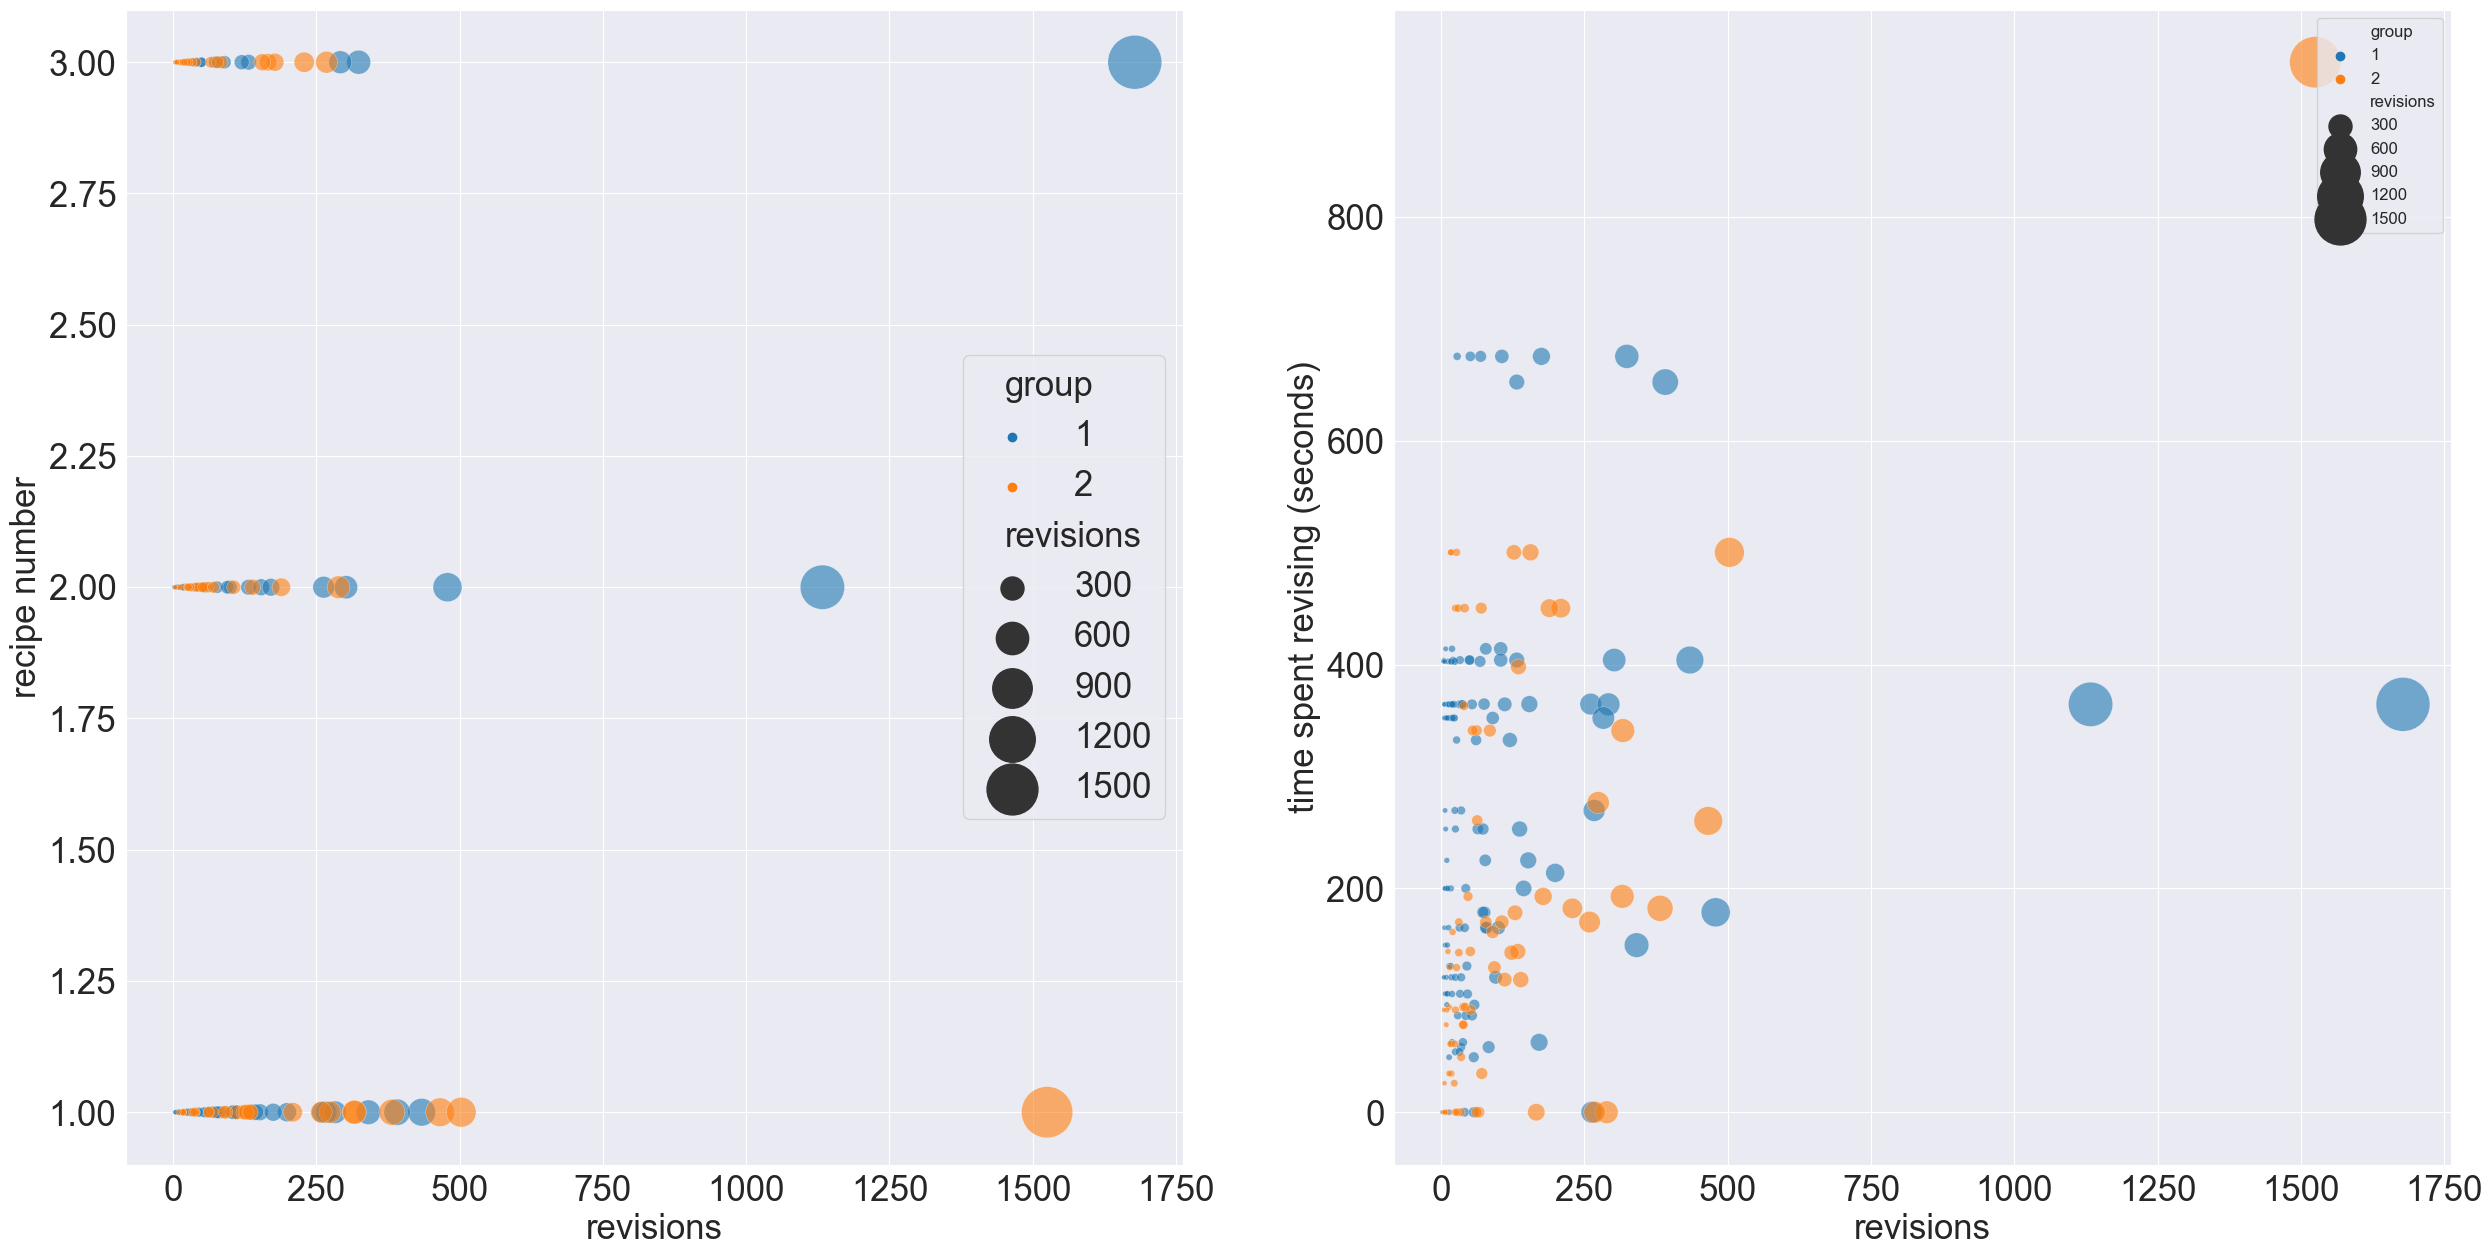

In [56]:
fig,ax = plt.subplots(1,2, figsize=(30,15))
without_outliers = dframe_with_n_recipes[(dframe_with_n_recipes["time spent revising (seconds)"] <= 1000) & (dframe_with_n_recipes["recipe number"] <= 3)]
sns.scatterplot(data=without_outliers, x="revisions", y="recipe number", size="revisions", hue="group", palette='tab10', alpha=0.6, sizes=(10, 1500), ax=ax[0])
sns.scatterplot(data=without_outliers, x="revisions", y="time spent revising (seconds)", size="revisions", hue="group", palette='tab10', alpha=0.6, sizes=(10, 1500), ax=ax[1])
plt.legend(fontsize=12)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


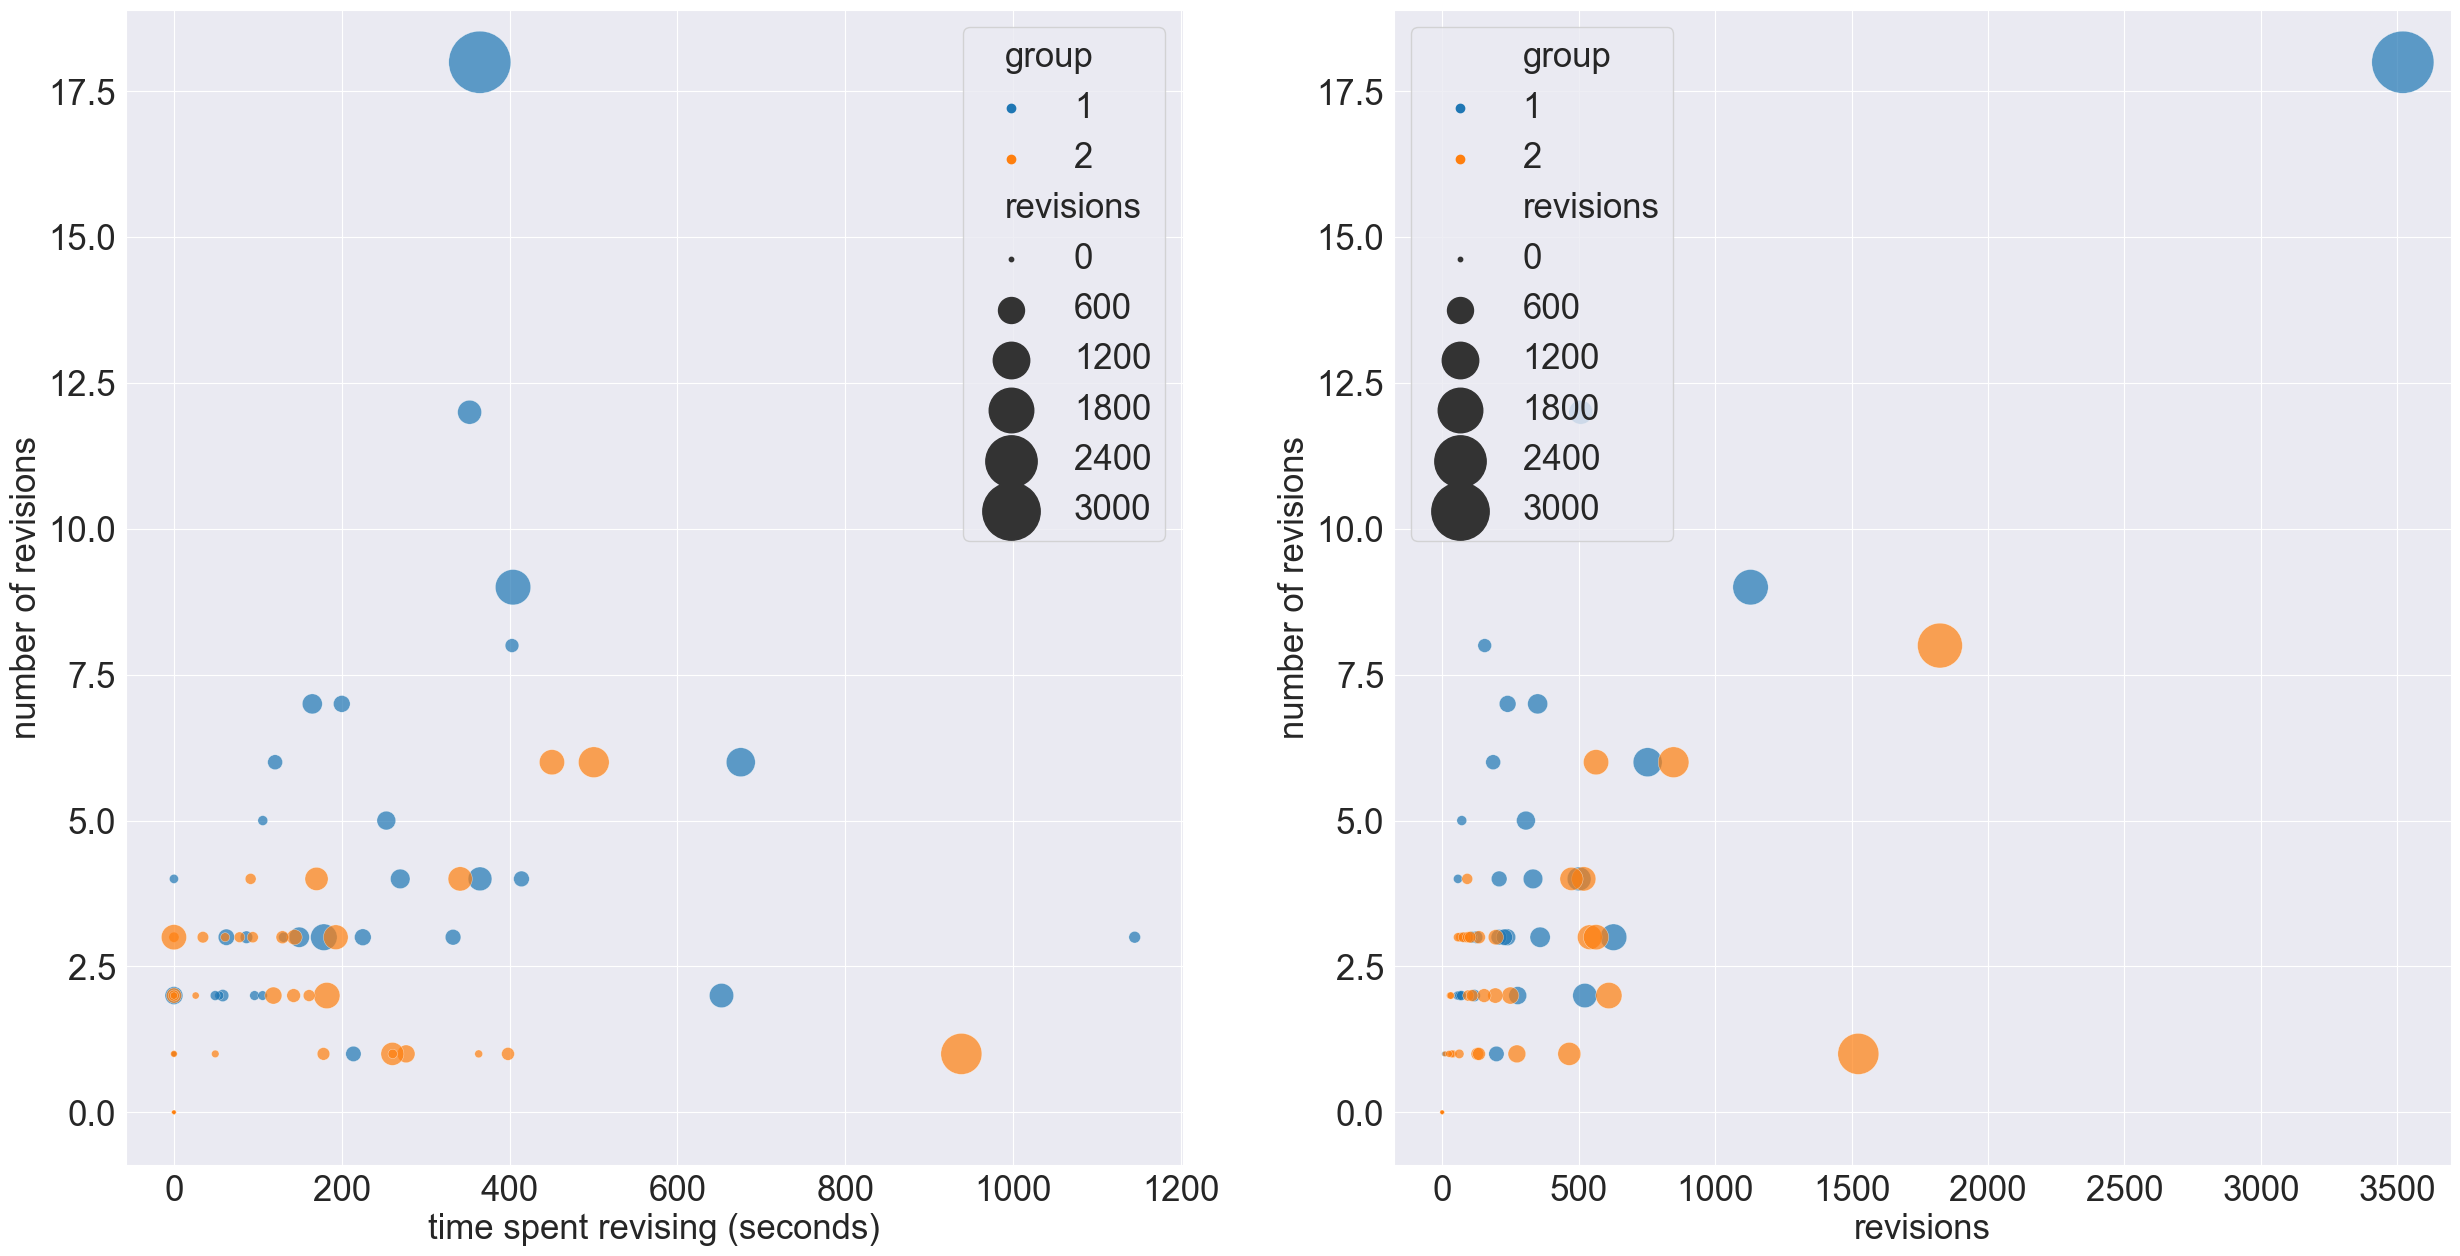

In [57]:
fig,ax = plt.subplots(1,2, figsize=(30,15))
sns.scatterplot(data=dframe_all_recipes_combined[dframe_all_recipes_combined['time spent revising (seconds)'] < 1500], x="time spent revising (seconds)", y="number of revisions", size="revisions", hue="group", palette='tab10', alpha=0.7, sizes=(10, 2000), ax=ax[0])
plt.legend(loc='upper left', fontsize=12)
sns.scatterplot(data=dframe_all_recipes_combined, x="revisions", y="number of revisions", size="revisions", hue="group", palette='tab10', alpha=0.7, sizes=(10, 2000), ax=ax[1])
plt.legend(loc='upper left', fontsize=25)

<AxesSubplot:xlabel='revisions', ylabel='Count'>

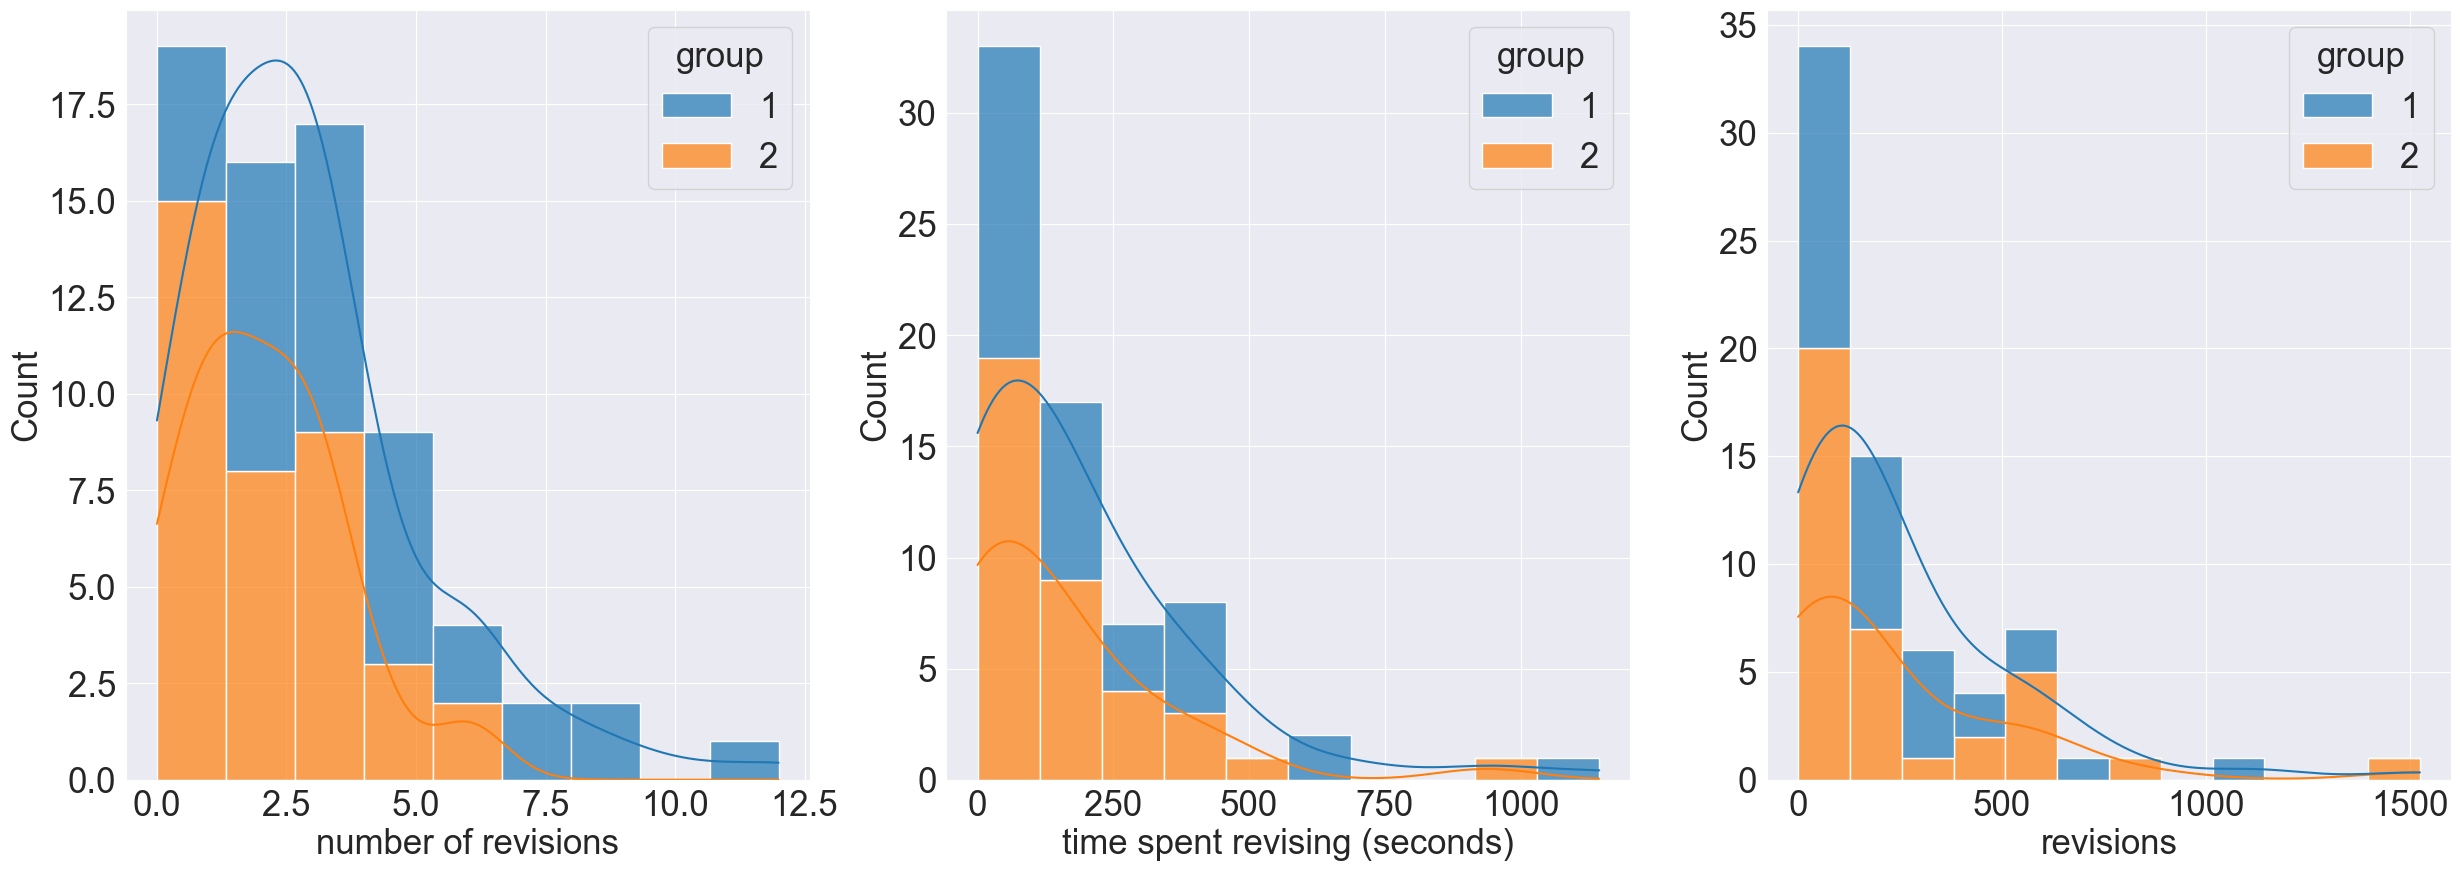

In [58]:
without_outliers = dframe_all_recipes_combined[(dframe_all_recipes_combined["time spent revising (seconds)"] <= 1500) & (dframe_all_recipes_combined["revisions"] <= 3000)]
fig,ax = plt.subplots(1,3, figsize=(30,10))
sns.histplot(data=without_outliers, x="number of revisions", hue="group", palette='tab10', alpha=0.7, multiple='stack', ax=ax[0], kde=True)
sns.histplot(data=without_outliers, x="time spent revising (seconds)", hue="group", palette='tab10', alpha=0.7, multiple='stack', ax=ax[1], kde=True)
sns.histplot(data=without_outliers, x="revisions", hue="group", palette='tab10', alpha=0.7, multiple='stack', ax=ax[2], kde=True)

## Comparing users inside a group

What we can do is find useful data for each user in a group ie:
* number of times they revised
* total time spent on the platform
* total number of revisions when revising 

In [59]:
from src.scripts.keystrokefeatures import ks_features

In [60]:
gender_data = matching_data['gender']
def get_features_for_group(group_number):
    #create an array as long as the number of indices in the group
    number_of_times_revised = [0] * len(INDICES[group_number-1])
    time_spent = [0] * len(INDICES[group_number-1])
    total_edits = [0] * len(INDICES[group_number-1])
    gender = [0] * len(INDICES[group_number-1])

    for i, user in enumerate(INDICES[group_number-1]):
        index_in_matching_data = np.where(matching_data['user_id'] == sorted_users[user])[0][0]
        gender_num = gender_data.iloc[index_in_matching_data]
        if gender_num == 1 : gender[i] = 'female'
        elif gender_num == 2 : gender[i] = 'male'
        else: gender[i] = 'other'
        time_spent[i] = get_total_time_spent_for_user(user)
        total_num_edits = 0
        max_times_revised = 0
        try:
            data = get_data_per_session(user)
        except: continue
        for session in data:
            if len(session) > 1:
                revision_sessions = session[1:]
                session_len = len(revision_sessions)
                max_times_revised = session_len if session_len > max_times_revised else max_times_revised
                for s in revision_sessions.values:
                    total_num_edits += s[0] + s[1]
               
        total_edits[i] = total_num_edits
        number_of_times_revised[i] = max_times_revised

    users = [sorted_users[user] for user in INDICES[group_number-1]]
    efficiencies = [ks_features[user]['efficiency'] for user in users]
    DIRatio = [ks_features[user]['DIRatio'] for user in users]
    
    result = pd.DataFrame([users, number_of_times_revised, time_spent, total_edits, gender, efficiencies, DIRatio]).T
    result.reset_index(inplace=True)
    result.columns = ['index', 'users', 'number of times revised', 'time spent', 'total edits', 'gender', 'efficiency', 'DIRatio']
    
    return result


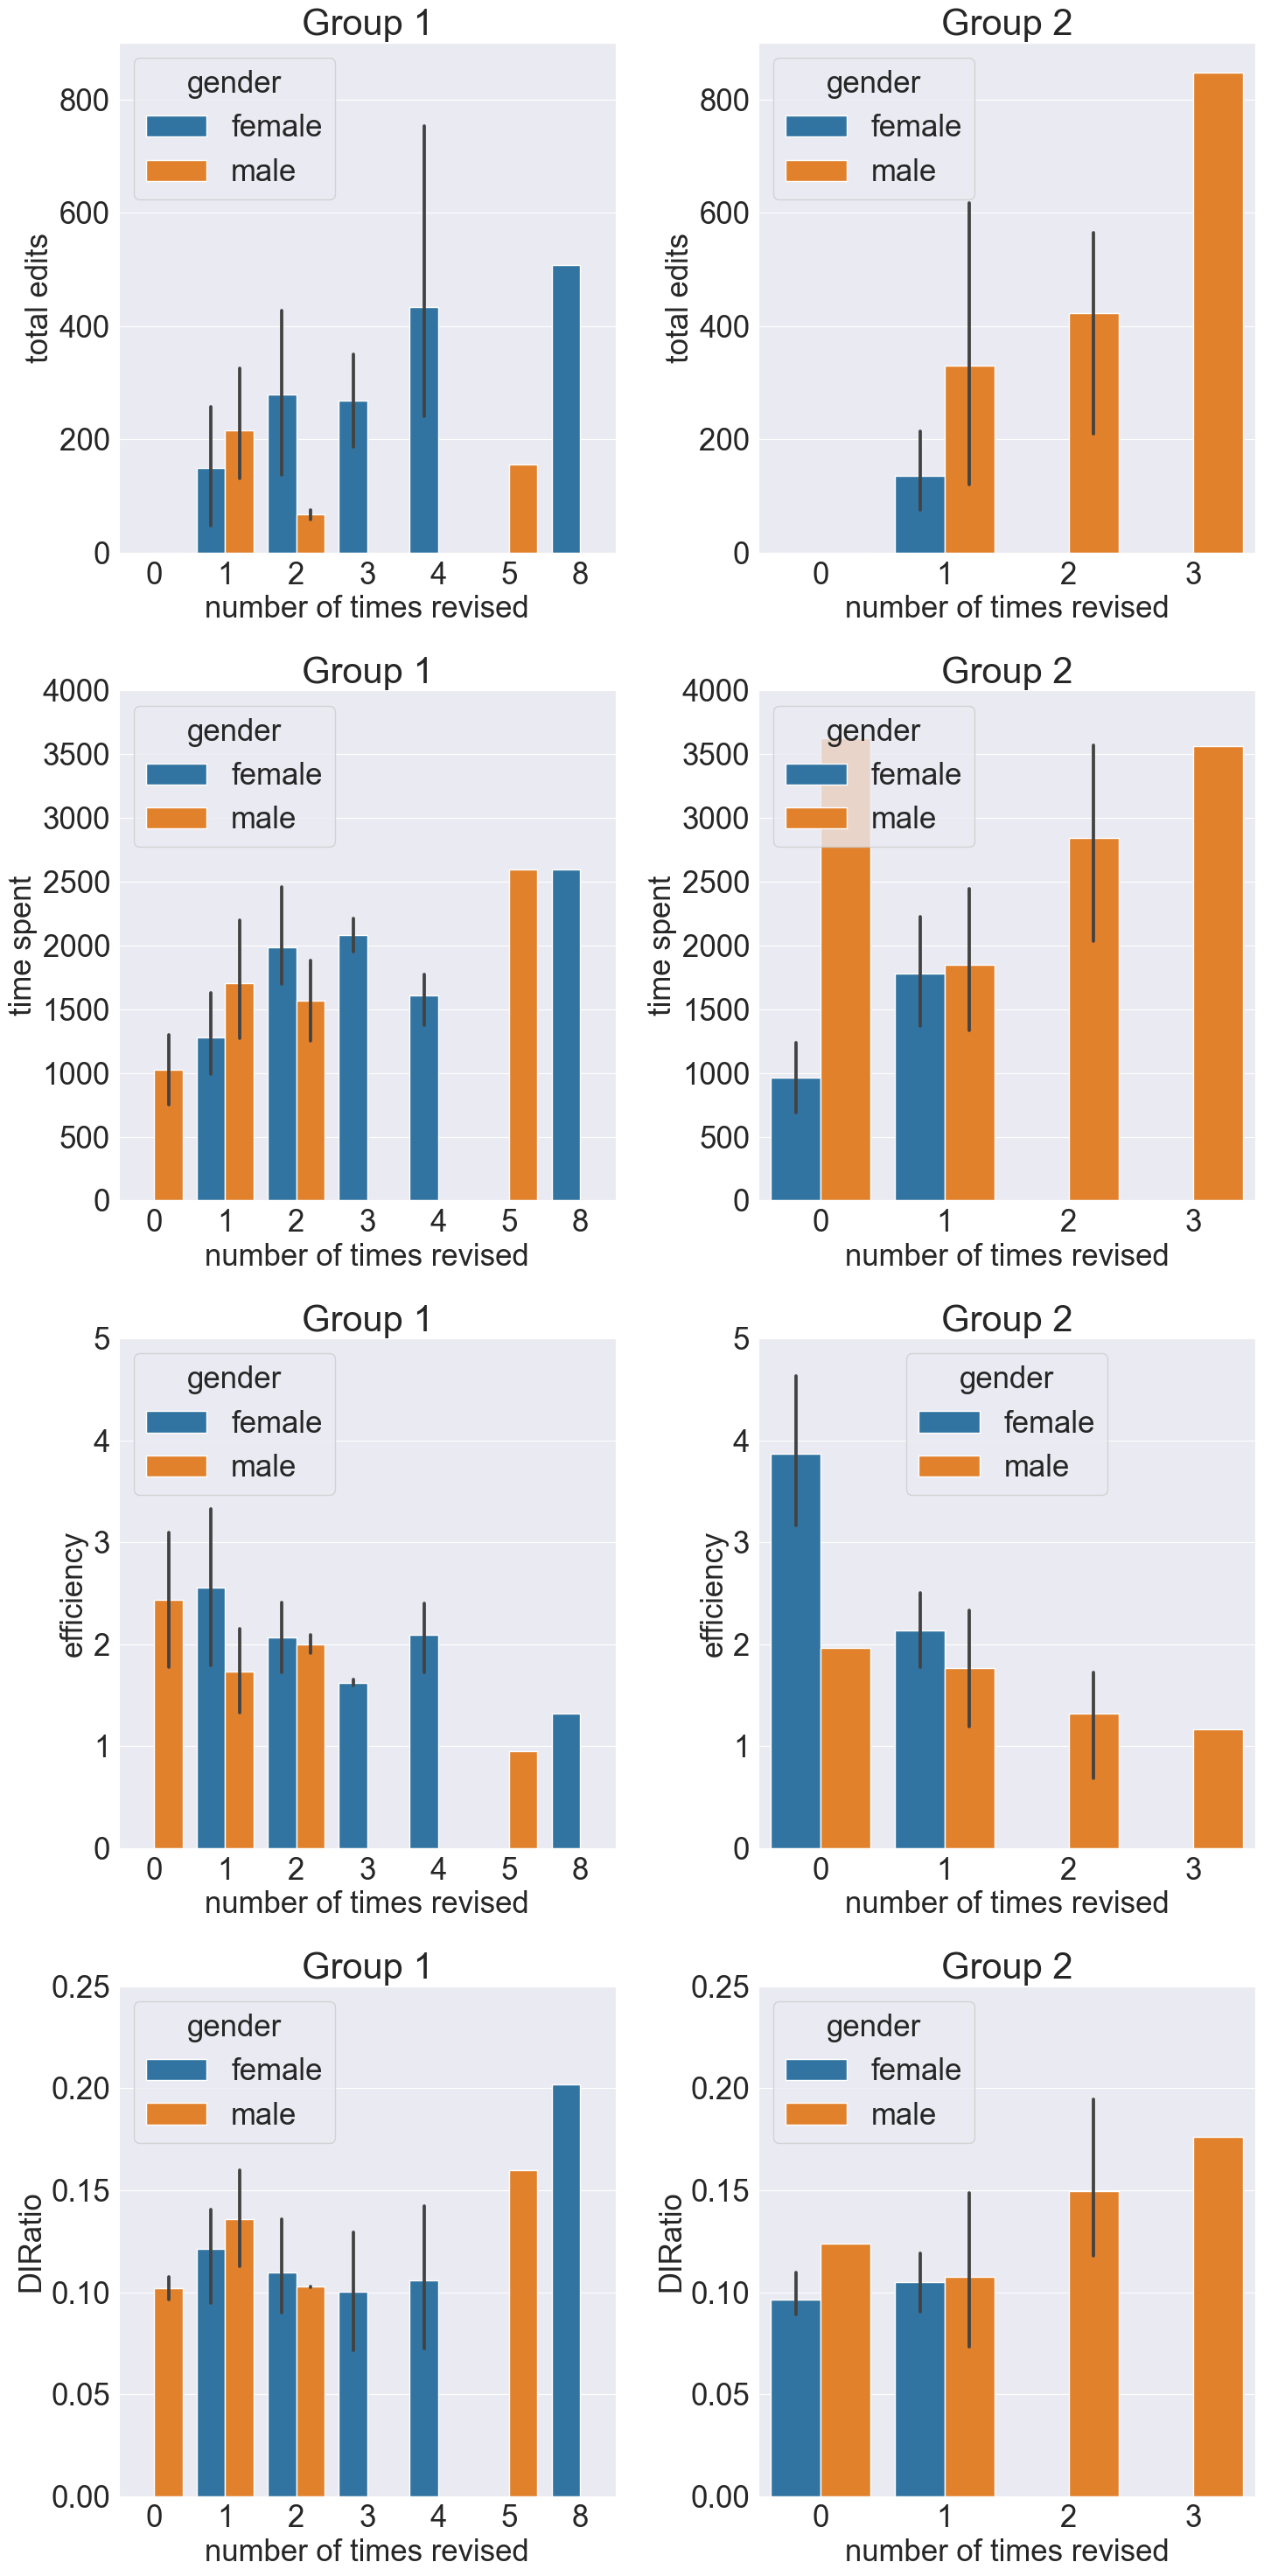

In [61]:
def gender_comparison_plot(vertical=False):
    num_rows = 4 if vertical else 2
    num_cols = 2 if vertical else 4
    x_size = 15 if vertical else 30
    y_size = 30 if vertical else 15
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(x_size, y_size))

    for i, group_number in enumerate([1,2]):    
            dfr = get_features_for_group(group_number=group_number)    
            dfr = dfr[(dfr['time spent'] < 10000) & (dfr['total edits'] < 1700) & ((dfr['gender'] != 'other'))]
    
            if not vertical:
                    sns.barplot(x=dfr['number of times revised'], y = dfr['DIRatio'] ,ax=ax[i][3], hue=dfr['gender']).set(title='Group {i}'.format(i=group_number))
                    sns.barplot(x=dfr['number of times revised'], y = dfr['total edits'] ,ax=ax[i][0], hue=dfr['gender']).set(title='Group {i}'.format(i=group_number))
                    sns.barplot(x=dfr['number of times revised'], y = dfr['time spent'] ,ax=ax[i][1], hue=dfr['gender']).set_title('Group {i}'.format(i=group_number))    
                    sns.barplot(x=dfr['number of times revised'], y = dfr['efficiency'] ,ax=ax[i][2], hue=dfr['gender']).set(title='Group {i}'.format(i=group_number))
            else:
                    sns.barplot(x=dfr['number of times revised'], y = dfr['total edits'] ,ax=ax[0][i], hue=dfr['gender']).set(title='Group {i}'.format(i=group_number))
                    sns.barplot(x=dfr['number of times revised'], y = dfr['time spent'] ,ax=ax[1][i], hue=dfr['gender']).set_title('Group {i}'.format(i=group_number))    
                    sns.barplot(x=dfr['number of times revised'], y = dfr['efficiency'] ,ax=ax[2][i], hue=dfr['gender']).set(title='Group {i}'.format(i=group_number))
                    sns.barplot(x=dfr['number of times revised'], y = dfr['DIRatio'] ,ax=ax[3][i], hue=dfr['gender']).set(title='Group {i}'.format(i=group_number))

    ylimits = [(0, 900),    (0, 4000),    (0, 5),    (0, 0.25)]
    for i in range(num_rows):
        for j in range(num_cols):
            ax[i][j].set_ylim(ylimits[i] if vertical else ylimits[j])
    plt.tight_layout()        
    plt.savefig('results/gender study/allgroups combined.png')
gender_comparison_plot(vertical=True)

Plotting individual features in case

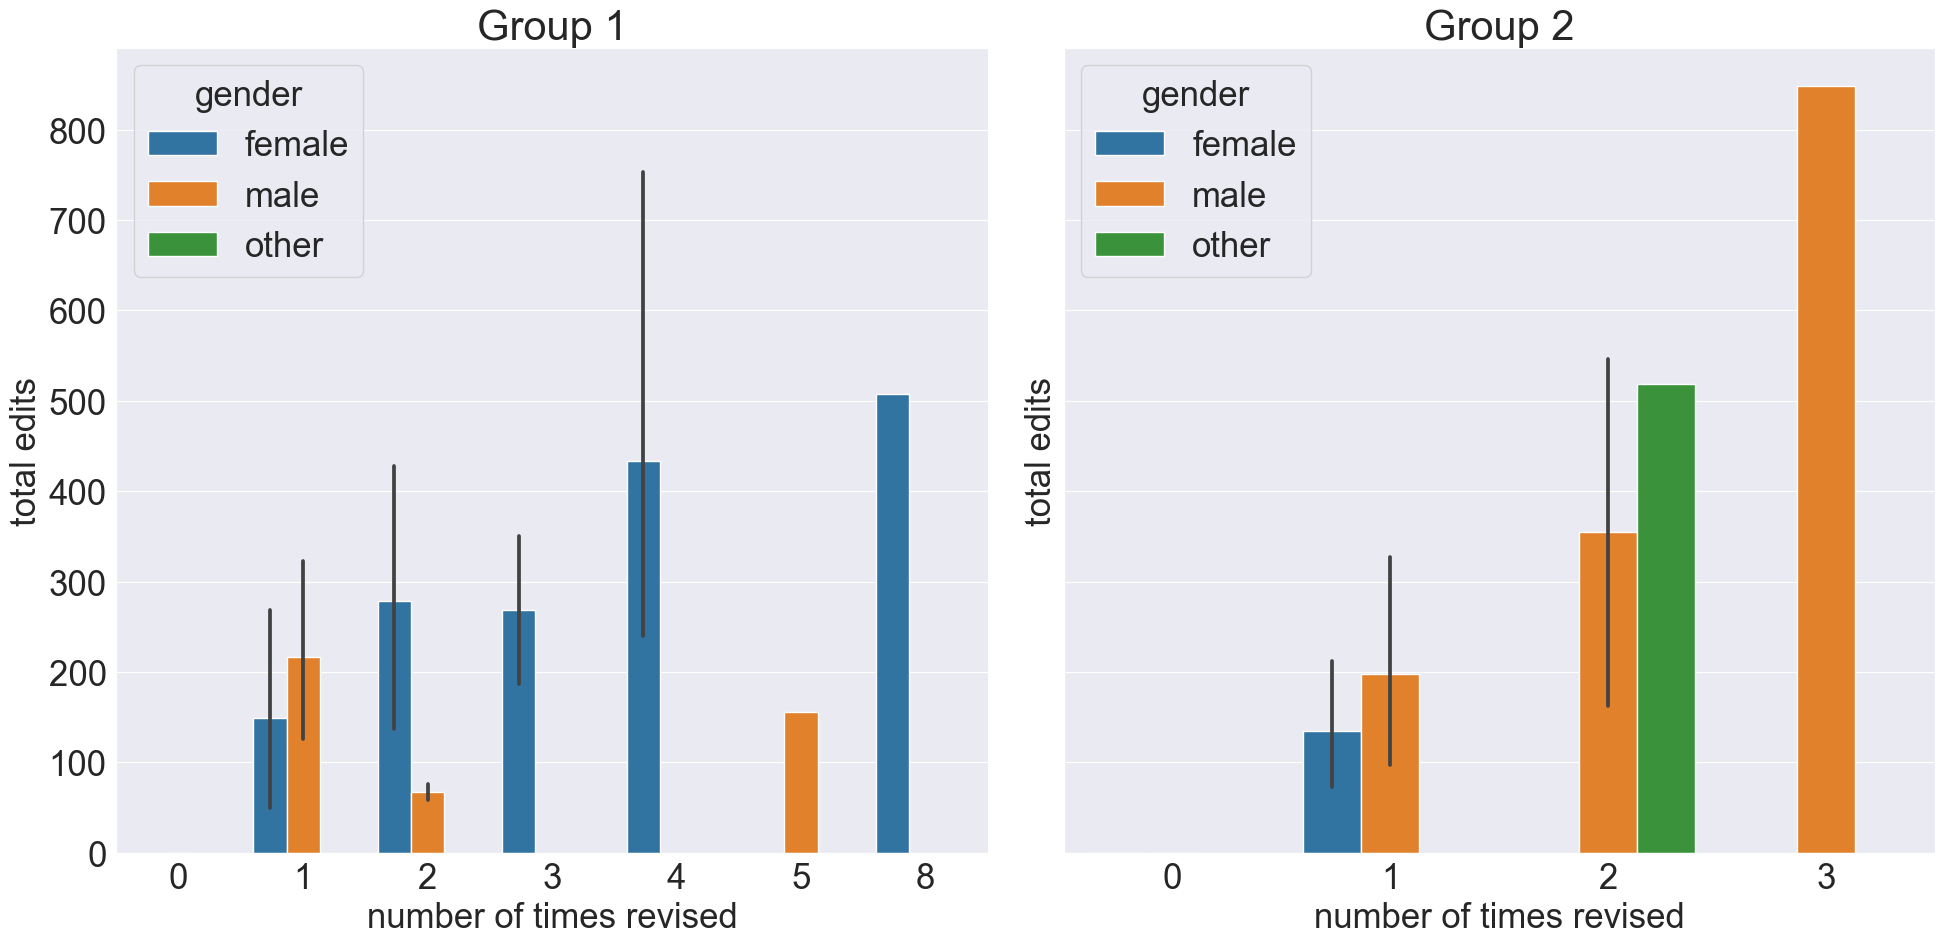

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
for group_number in [1,2]:
    dfr = get_features_for_group(group_number=group_number)  
    df_without_outliers=dfr[(dfr['total edits'] < 1000)]
    sns.barplot(x=df_without_outliers['number of times revised'], y = df_without_outliers['total edits'] ,ax=ax[group_number-1], hue=dfr['gender']).set(title='Group {i}'.format(i=group_number))
    plt.tight_layout()
    plt.savefig('results/gender study/num revisions plots.png')

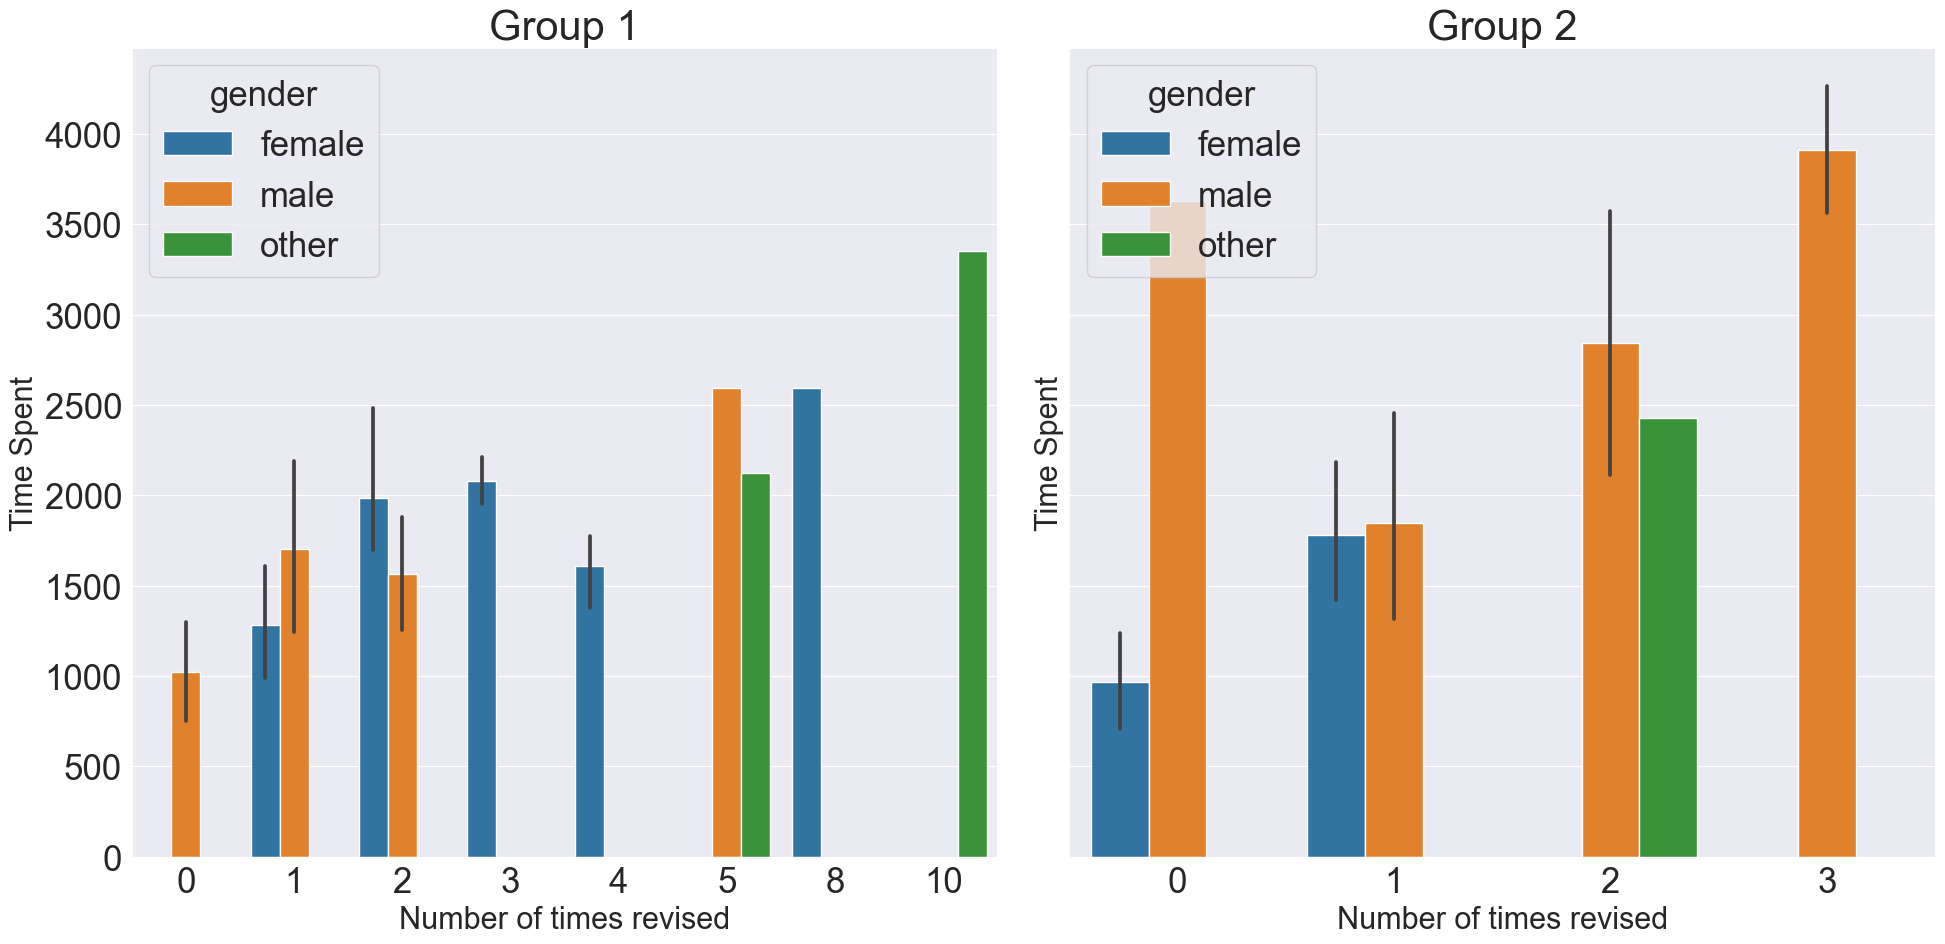

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

for group_number in [1,2]:
    dfr = get_features_for_group(group_number=group_number)  
    df_without_outliers=dfr[(dfr['time spent'] < 10000)]
    sns.barplot(x=df_without_outliers['number of times revised'], y = df_without_outliers['time spent'] ,ax=ax[group_number-1], hue=dfr['gender']).set(title='Group {i}'.format(i=group_number))
    xlabel = plt.gca().xaxis.label
    ax[0].set_xlabel('Number of times revised', fontsize=22)
    ax[1].set_xlabel('Number of times revised', fontsize=22)
    ax[0].set_ylabel('Time Spent', fontsize=22)
    ax[1].set_ylabel('Time Spent', fontsize=22)
    
    plt.tick_params(axis='y', labelsize=40)

    plt.tight_layout()
    plt.savefig('results/gender study/time spent plots.png')

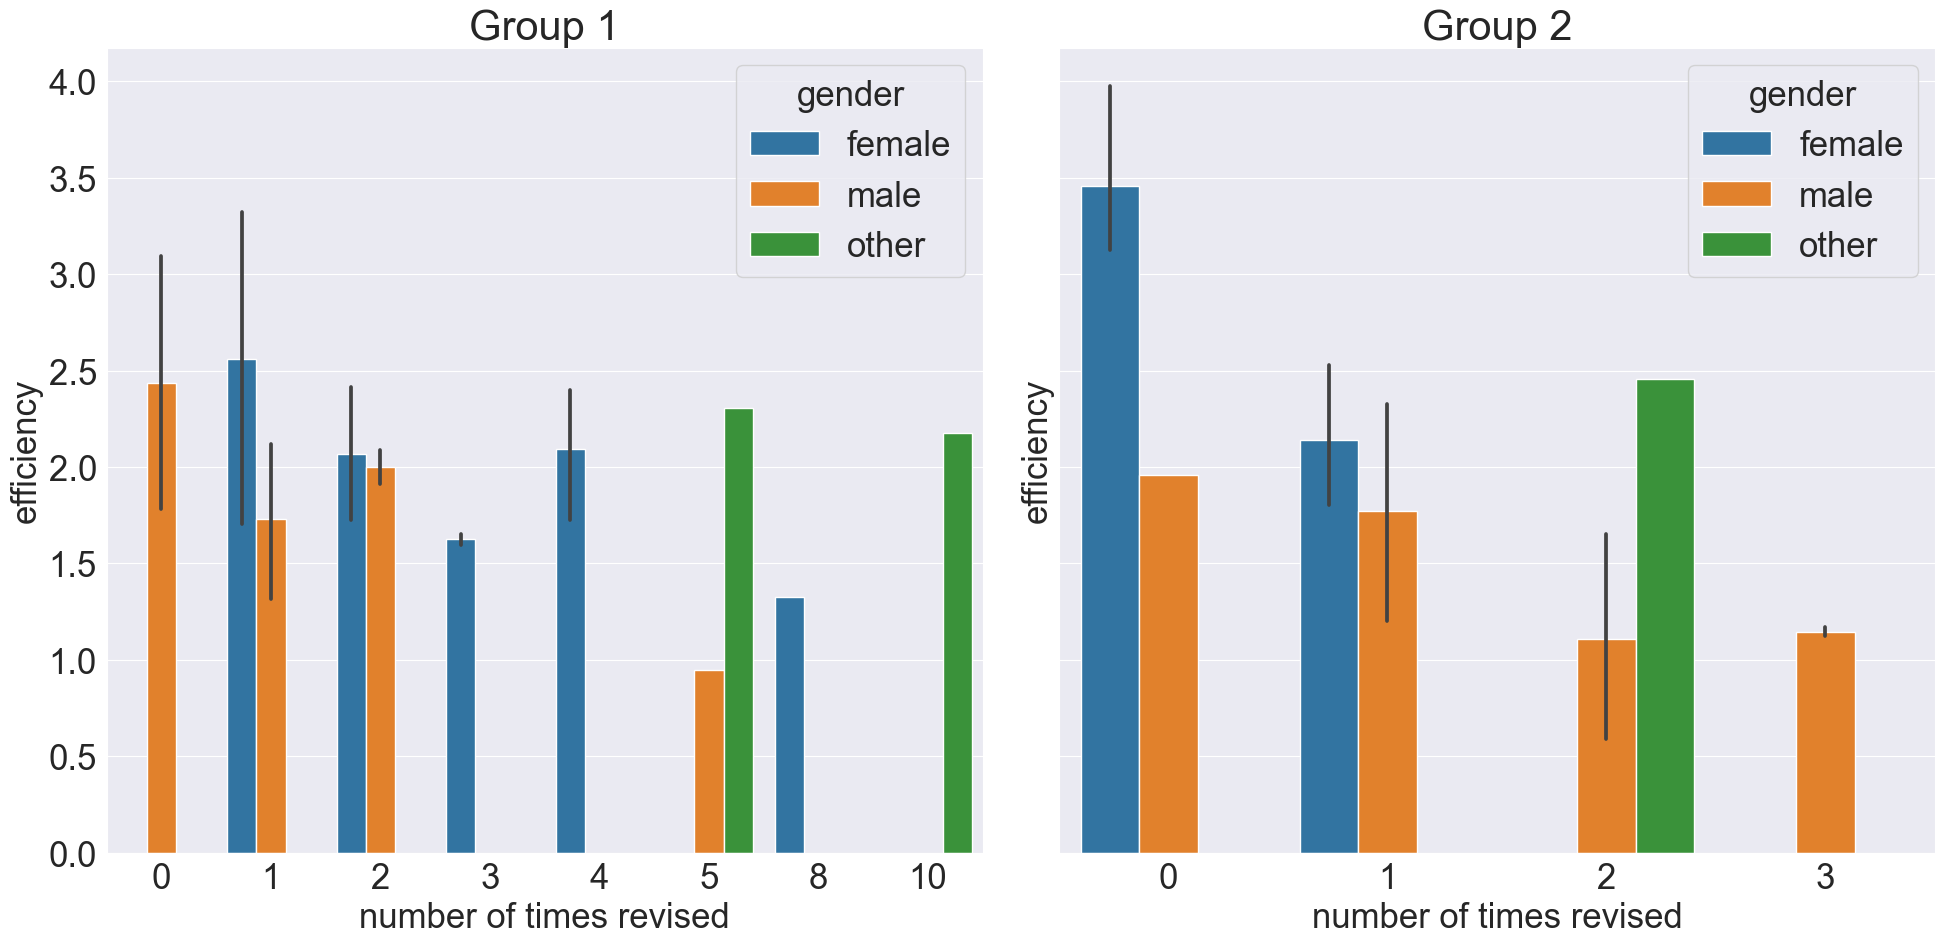

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
for group_number in [1,2]:
    dfr = get_features_for_group(group_number=group_number)  
    df_without_efficiency_outliers=dfr[(dfr['efficiency'] < 5) & (dfr['efficiency'] > 0.1)]
    sns.barplot(x=df_without_efficiency_outliers['number of times revised'], y = df_without_efficiency_outliers['efficiency'] ,ax=ax[group_number-1], hue=dfr['gender']).set(title='Group {i}'.format(i=group_number))
    plt.tight_layout()
    plt.savefig('results/gender study/efficiency plots.png')

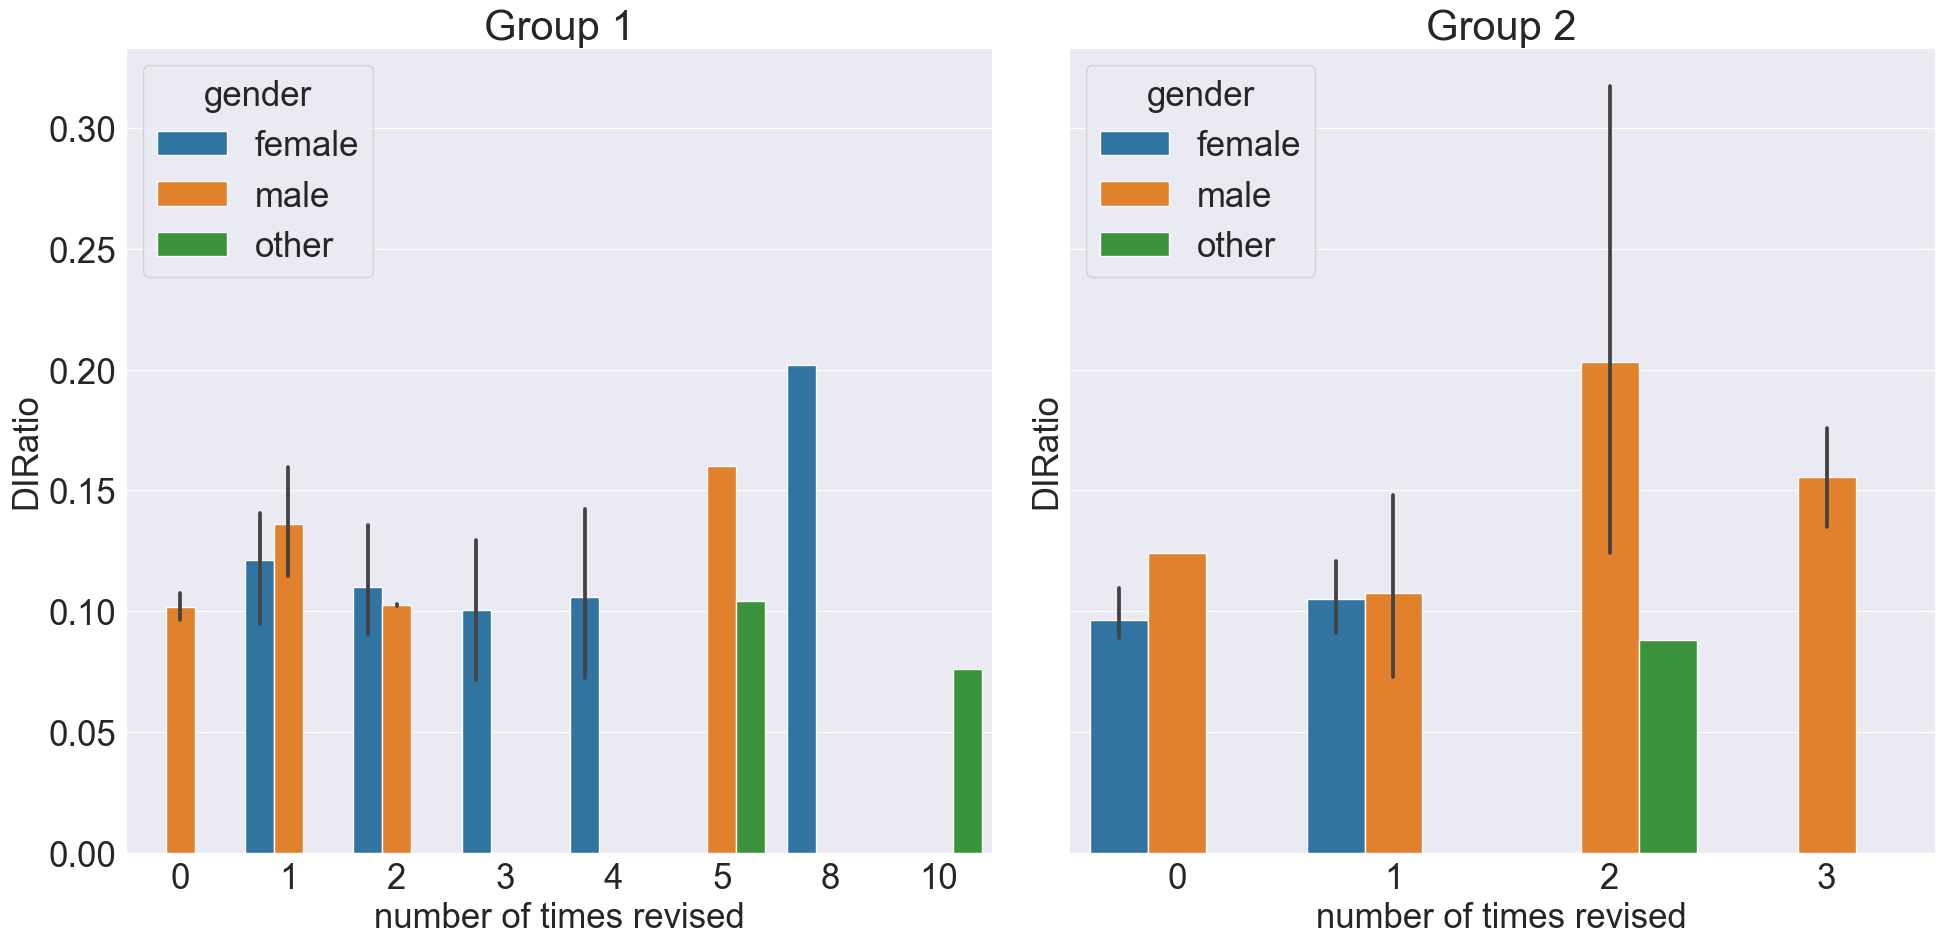

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
for group_number in [1,2]:
    dfr= get_features_for_group(group_number=group_number)  
    sns.barplot(x=dfr['number of times revised'], y = dfr['DIRatio'] ,ax=ax[group_number-1], hue=dfr['gender']).set(title='Group {i}'.format(i=group_number))
    plt.tight_layout()
    plt.savefig('results/gender study/DIRatio plots.png')

# Future Directions

## Providing qualitative analysis

Here is a kickstarter

In [66]:
column_names = ['first recipe edits', 'second recipe edits', 'third recipe edits']
matching_data = matching_data.sort_values(by='group')

def compute_summaries_on_group_at_recipe(group, recipe_num):
    indices_for_group = matching_data[matching_data['group'] == group].index
    summaries = []
    for index in indices_for_group:
        edit = matching_data.iloc[index][column_names[recipe_num-1]]
        summaries.append(utils.summarize(edit))
    return summaries
    
def compute_summaries_for_group(group):
    summaries_for_group = []
    for recipe_num in [1,2,3]:
        summaries_for_group.append(compute_summaries_on_group_at_recipe(group, recipe_num))
    return utils.flatten(summaries_for_group)


summaries_group1 = compute_summaries_for_group(1)

Maybe try clustering to group similar revisions together. Then apply clustering again but between the groups to visualise.